In [1]:
import sys
sys.path.append('e:\solar flares\data\\2017-09-06')


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_12492\607442616.py:2: SyntaxWarning: invalid escape sequence '\s'
  sys.path.append('e:\solar flares\data\\2017-09-06')


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import use_nessi as un
import use_nessi2 as un2
# import os
from importlib import reload

# from matplotlib import cm
# import matplotlib.cbook as cbook
# import matplotlib.colors as colors
# from scipy.interpolate import interp1d
from PIL import Image
from matplotlib import transforms



sr = solar_radius = 959.63
area_factor = 60**2/np.pi/sr**2

In [3]:
import scipy

    
def get_data(lines):
    data = un.load_for_further_analysis(lines, un.get_full_path(lines[0]))
    for line in lines:
        if "CaK" in line:
            un2.disgard_cont_point(line, data)
    
    return data 

def index_match(lines, name):
    for i, line in enumerate(lines):
        if line in name:
            return i
    raise IndexError(f'No line in lines (={lines}) matches {name}. ')
    
def ax_contr(wav, time, DFD, name, line, ax, fig, cmap='RdBu_r'):
        W, T = np.meshgrid(wav, time)
        print("scaled flare: Line", name)

        un2.ax_contrastplot(fig, ax, W, T, DFD, wav, line, decorations={"title":latex_name(name)}, seperate_colorbar=True, vlim=None, cmap=cmap)

class timelim():
    def __init__(self):
        self.mins = []
        self.maxs = []
        
    def add_timestap(self, times):
        self.mins.append(np.min(times))
        self.maxs.append(np.max(times))
        
    def get_lim(self):
        return (min(self.mins), max(self.maxs))
        

def Full_line_ana(fig, ax, names_of_lines_list, scalefactor, name_of_flare='', name_of_show_line=None, data=None):
    fig.supylabel("Minutes from start of flare [min]")
    fig.supxlabel(r"Wavelength [$\rm\AA$]")
    
    TL = timelim()
    
    if data is None:
        data = get_data(names_of_lines_list)
    for i, name in enumerate(names_of_lines_list):
        wav, DFD , time, line, std = un2.contrast_FD_data(name,data, quiet_sun_subtraction=False, 
                                                          area_factor=area_factor*scalefactor, add_noise=False)
        TL.add_timestap(time)
        params, voigt, res = load_voigt_data(name, wav)
        cmap = 'RdBu_r' if data[f'True_nessi_{name}'] else 'viridis'
        ax_contr(wav, time, DFD, name, line, ax[0, i], fig, cmap=cmap)
        c = area_factor*scalefactor
        ax_visualize_analysis(ax[1, i], c*res, c*voigt, wav, time, name, cmap=cmap)
    lim = TL.get_lim()
    for i in range(len(names_of_lines_list)):
        ax[0, i].set_ylim(lim)
        ax[1, i].set_ylim(lim)
        
    flarename = flarename_from_title(name_of_flare)

    plot_DEW(ax[0, -1], data, names_of_lines_list, scalefactor, flarename, TL)
    if name_of_show_line is None:
        name_of_show_line = names_of_lines_list[0]
    ax_mu_frame(ax[1, -1], name_of_show_line)
    
    # plot_W(ax[0, -2], data, names_of_lines_list, scalefactor)

    ax[0, 0].set_ylabel(f"Contrast profile")
    ax[1, 0].set_ylabel("Voight + Residuals")
    
    in_latex_fig(name_of_flare, names_of_lines_list, scalefactor, data)
    
    # Rotate x-ticks in all subplots
    for ax in fig.get_axes():
        ax.tick_params(axis='x', which='major', rotation=-23)  # Rotate x-ticks by 45 degrees
    
def color_for_name(name):
    colors = {'Ha':'red', 'CaK':'blue', 'CaI':"yellow", "Fe":"darkgreen", "Hbeta":"purple", "He":"lightgreen"}
    for line in colors:
        if line in name:
            return colors[line]
    raise ValueError(f'The given name {name} is not linked to a color yet.')

def plot_W(ax, data, names, scalefactor, shift=False):
    under_bound=0
    for name in names:
        W, time = calculate_W(data, name, scalefactor)
        W = np.array(W)
        scale = round(np.log(max(np.max(W), -np.min(W)))/np.log(10)) if len(names)>1 else 0
        a = (np.average(W / (10**scale)) if shift else 0)
        print(a)
        ax.plot(
            time,
            W / (10**scale) - a ,
            '--',
            color=color_for_name(name),
            label=f"""{latex_name(name)}{f", x10^{str(scale)}" if scale != 0 else ''}""",
        )
        under_bound = min(np.percentile(W/10**scale, 2), under_bound)
    ax.set_title(r'Time evolution of the width $W$ with $\Delta \lambda = 4 \rm\AA$. ')
    ax.set_xlabel('Time from begin of flare [min]')
    ax.set_ylabel(r'$W$ $[\rm\AA]$')
    if under_bound<0:
        ax.set_ylim(bottom=under_bound, top=None)  # Set top to None to avoid automatic adjustment
    ax.legend()
    
def calculate_W(data, name, scalefactor=1, Dlambda=4):
    sr = 959.63
    area_factor= 60**2/np.pi/sr**2*scalefactor
    
    wav, DS, time, line, std = un2.contrast_FD_data(name, data, quiet_sun_subtraction=False, num=100,area_factor=area_factor, add_noise=False)
    
    DS -= 1 
    # wav, DFD , time, line, std = un2.difference_FD_data(name,data, quiet_sun_subtraction=False, area_factor=area_factor,
    #                                                   add_noise=False)

    line_center = wav[np.where(line == np.min(line))[0][0]]
    interval = [line_center-Dlambda, line_center+Dlambda]
    
    W = []

    for frame in range(np.shape(time)[0]):
        

        x, restx = un.restrict_intervalx2(interval, wav)
        # print(np.shape(x), np.shape(restx(DFD)), x, DFD[frame] )
        DSL2 = DS * (wav - line_center) **2

        W.append( 
                   scipy.integrate.simpson(y=restx(DSL2[frame]), x=x, dx=1.0, axis=-1, even='avg')/
                   scipy.integrate.simpson(y=restx(DS[frame]), x=x, dx=1.0, axis=-1, even='avg'))

    return W, time
 
def plot_DEW(ax, data, names, scalefactor, flarename, timelim, GOES=True, shift=False):
    under_bound = 0
    upper_bound = 0
    for name in names:
        dew, time = DEW(data, name, scalefactor)
        dew = np.array(dew)
        scale = round(np.log(max(np.max(dew), -np.min(dew)))/np.log(10), 1) 
        ax.plot(
            time,
            (dew / (10**scale)),
            '-o',
            color='black',
            markerfacecolor=color_for_name(name),
            markeredgewidth=0.5,
            markersize=5,
            label=latex_name(name) # f"""{latex_name(name)}{f", x10^{str(scale)}" if scale != 0 else ''}"""
        )
        under_bound = min(np.min(dew/10**scale), under_bound)
        upper_bound = max(np.max(dew/10**scale), upper_bound)
        
        print(name, 'Bounds:', upper_bound, under_bound)
    ax.set_ylim(bottom=under_bound, top=upper_bound)  # Set top to None to avoid automatic adjustment
    if GOES:
        add_GOES(ax, flarename, timelim, upper_bound, under_bound)
        
    ax.set_title(r' $\Delta EW $ with $\Delta \lambda = 0.5 \rm\AA$. ')
    ax.set_xlabel('Time from begin of flare [min]')
    ax.set_ylabel(r'$\Delta EW ~[\rm\AA]$')
    ax.legend()

def DEW(data, name, scalefactor=1, Dlambda=0.5):
    sr = 959.63
    area_factor= 60**2/np.pi/sr**2*scalefactor
    
    wav, DFD , time, line, std = un2.difference_FD_data(name,data, quiet_sun_subtraction=False, area_factor=area_factor,
                                                      add_noise=False)

    line_center = wav[np.where(line == np.min(line))[0][0]]
    interval = [line_center-Dlambda, line_center+Dlambda]
    
    DEW = []

    for frame in range(np.shape(time)[0]):
        

        x, restx = un.restrict_intervalx2(interval, wav)
        # print(np.shape(x), np.shape(restx(DFD)), x, DFD[frame] )

        DEW.append( scipy.integrate.simpson(y=restx(DFD[frame]), x=x, dx=1.0, axis=-1, even='avg'))

    return DEW, time

def gaussian(x, amp_g, cen_g, sigma_g):
    """Gaussian function."""
    return amp_g * np.exp(-(x - cen_g)**2 / (2 * sigma_g**2))

def lorentzian(x, amp_l, cen_l, gamma_l):
    """Lorentzian function."""
    return amp_l * (gamma_l**2 / ((x - cen_l)**2 + gamma_l**2))

def voigt(x, param, offset=0):
    """Voigt profile: approximation by combining Gaussian and Lorentzian."""
    amp_v, cen_v, sigma_v, gamma_v = param
    f_g = sigma_v**2 / (sigma_v**2 + gamma_v**2)
    return (f_g * gaussian(x, 1, cen_v, sigma_v) +
            (1 - f_g) * lorentzian(x, 1, cen_v, gamma_v)) * amp_v + offset

def load_voigt_data(name, wav):
    fname = f"E:/solar flares/data/voigt_fitting/fit_data/voigt_data_{name}.npz"
    data =  np.load(fname) 
    params = data['arr_0']
    res = data["arr_1"]
    s = lambda x : x[0] if len(x) == 2 else x
    voigt_data= np.array([ voigt(wav, s(param)) for param in params]) 
    return params, voigt_data, res    

def latex_name(name): 
    names = {"Ha":r"$\rm{H}\alpha$", 
             "CaK":r'$\rm{Ca}~\rm{II}~\rm{K}$', 
             "CaIR":r'$\rm{Ca}~\rm{II}~8542~\rm{\AA}$', 
             "Fe6173":r'$\rm{Fe}~6173~\rm{\AA}$', 
             "Hbeta":r'$\rm{H}\beta$', 
             "CaK(2)":r'$\rm{Ca}~\rm{II}~\rm{H}$', 
             "He":r'$\rm{He}~5832\rm{\AA}$'}
    el = un2.element_from_name(name)
    try:
        return names[el]
    except:
        raise ValueError(f"Name {names} is not found in the keys {names.keys()}.")

def cut_off_data(data, up_lim=None, down_lim=None):
    if up_lim is None and down_lim is None:
        up_lim = max(-np.percentile(data, 3), np.percentile(data, 97))
        down_lim = - up_lim
    elif up_lim is None:
        up_lim = np.percentile(data, 97)
    elif down_lim is None:
        down_lim = np.percentile(data, 3)
    # Apply cutoff using boolean indexing and conditional assignment
    cutoff_data = np.where(data > up_lim, up_lim, data)
    cutoff_data = np.where(data < down_lim, down_lim, cutoff_data)
    return cutoff_data

def replace_outliers(data, nsigma):
  """
  Detects outliers in a NumPy array and replaces them with the 2 sigma value in their direction.

  Args:
      data: A 1D NumPy array.

  Returns:
      A new 1D NumPy array with outliers replaced by 2 sigma values.
  """

  # Calculate mean and standard deviation
  med = np.median(data)
  std = np.std(data)

  # Define 2 sigma threshold (both upper and lower)
  lower_bound = med - nsigma * std
  upper_bound = med + nsigma * std

  data_replaced = np.where(data > lower_bound, data, lower_bound)
  data_replaced = np.where(data < upper_bound, data_replaced, upper_bound)

  return data_replaced

def ax_visualize_analysis(ax, res, voigt_data, wav, time, name, non_centered=True, cmap='RdBu_r'):
    el = un2.element_from_name(name)
    print("plotting element", el, "name:", name)
    if True: #el in ["Fe6173", "CaIR", "Ha", "He", "CaK"]:
        if non_centered:
            vmax = np.percentile(res, 97)
            vmin = np.percentile(res, 3)
        else:
            vmax = max(-np.percentile(res, 3), np.percentile(res, 97))
            vmin =-vmax
            
        if "19" in name:
            print("the special flare")
            # vmin = np.percentile(res, 3)
            voigt_data= replace_outliers(voigt_data, 2)
        print(f"{vmax = }, {vmin = }")
        c = ax.imshow(np.array(res), aspect="auto", cmap=cmap, origin='lower', extent=(wav[0], wav[-1], time[0], time[-1]),
                    vmax=vmax, vmin=vmin)

    else:
        c = ax.imshow(np.array(res), aspect="auto", cmap=cmap, origin='lower', extent=(wav[0], wav[-1], time[0], time[-1]))
    # pcm = ax.pcolormesh(X, Y, Z, cmap='RdBu_r',vmin=-np.max(Z),  shading='auto')
    cb = fig.colorbar(c, ax=ax, extend='both')
    X, Y = np.meshgrid(wav, time)
    CS = ax.contour(X, Y, voigt_data, colors='black', alpha=0.5)
    ax.clabel(CS, inline=True, fontsize=10) 
    ax.set_title(latex_name(name))

    # ax.set_xlabel(r"Wavelength [$\rm\AA$]")
    # cb.set_label(r'the residues after Voigt fit [relative intensity]')
    

def load_mu_frame(name):
    data = np.load(f"{un.get_full_path(name)}/line_data/contourdata{name}.npz")
    x = data["arr_1"]
    y = data["arr_2"]
    X, Y = np.meshgrid(x, y)
    ccp = data["arr_3"]
    extent = (np.min(x), np.max(x), np.min(y), np.max(y))
    rotation = data.get("arr_4", 0)
    MU, X, Y = square_full_mu_mesh(X, Y, angle=rotation)
    return MU, X, Y, ccp, extent, rotation

def square_full_mu_mesh(X,Y, angle, num=200):
    X = np.array([np.min(X), np.max(X)])
    Y = np.array([np.min(Y), np.max(Y)])
    X,Y = np.meshgrid(X,Y)
    X,Y = rotate_mesh_around_average(X,Y, angle)
    X = np.linspace(np.min(X), np.max(X), num)
    Y = np.linspace(np.min(Y), np.max(Y), num)
    X,Y = np.meshgrid(X,Y)
    MU = calculate_mu(X,Y)
    return MU, X, Y

def calculate_mu(x,y, radius=959.63):
    rad_dist =  (x**2 + y**2)**0.5/radius
    return np.cos(np.arcsin(rad_dist))

def rotate_mesh_around_average(xx, yy, angle):
  # Calculate the average x and y coordinates
  avg_x = np.mean(xx)
  avg_y = np.mean(yy)

  # Shift the mesh to center it around the average
  xx_centered = xx - avg_x
  yy_centered = yy - avg_y

  # Rotate the centered mesh coordinates
  xx_rot = np.cos(angle) * xx_centered -np.sin(angle) * yy_centered  + avg_x
  yy_rot = np.sin(angle) * xx_centered + np.cos(angle) * yy_centered + avg_y

  return xx_rot, yy_rot

def local_rotation(extent, rad_rot):
    mid = extent2mid(extent)
    x = np.array(mid) 
    R = np.array([[np.cos(rad_rot), -np.sin(rad_rot)], [np.sin(rad_rot), np.cos(rad_rot)]])
    y = np.dot(R, x)
    t = x-y
    return transforms.Affine2D().rotate_deg(rad_rot/np.pi*180).translate(t[0], t[1])

def extent2mid(extent):
    return ((extent[0]+extent[1])/2, (extent[2]+extent[3])/2)


def ax_mu_frame(ax, name):
    MU, X, Y, ccp, extent, rotation = load_mu_frame(name)
    
    tr = local_rotation(extent, rotation)
    ax.imshow(Image.fromarray(ccp), transform=tr + ax.transData, origin='lower', extent=extent)
    CS = ax.contour(X, Y, MU)
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_title(r'Contour plot $\mu$-value')
    ax.set_xlabel('X [arcsec]')
    ax.set_ylabel('Y [arcsec]')
   
def bold(str):
    return "\\textbf{"+str+"}"

def cmd_name(name):
    names = {"Ha":r"\Halpha", "CaK":'\\CaK', "CaIR":'\\CaIR', "Fe6173":'\\Fe{6173}', "Fe6302":'\\Fe{6302}', 
             "Hbeta":r'\Hbeta', "He":r'\He5832', "CaK(2)":r'\\CaH'}
    el = un2.element_from_name(name)
    try:
        return names[el]
    except:
        raise ValueError(f"Name {names} is not found in the keys {names.keys()}.")
    
def opsomming(ls_str):
    k = len(ls_str) 
    if k == 1:
        return ls_str[0]
    elif k == 2:
        return f"{ls_str[0]} and {ls_str[1]}"
    elif k>2:
        return f'{ls_str[0]}, {opsomming(ls_str[1:])}'
    else:
        raise IndentationError(' something here is not correct cannot be empty of else;..; poisjfmlksfj')
    
def no_or_pos(n):
    return f' {n}' if n > 1 else ""

def give_descr(title, lines, scalefactor, data=None):
    return f"""
    {bold(f'The full {title}:')} NESSI calculated full disk profiles 
    for ~{round(1/scalefactor * 100)}\\% flare capture. {bold(f'Upper left{no_or_pos(len(lines))}:')} 
    Contrastprofiles to the quiet sun for the lines {opsomming([cmd_name(line) for line in lines])}.
    {bold(f'Lower left{no_or_pos(len(lines))}:')} voigtprofile fits to the respective contrastprofiles above are 
    shown using a contourmap, the residues to those fitting are shown using a color map. {remark_colormap(lines, data)}
    {bold('upper right:')} Differential Equivalent Width of the available lines as a function of time. 
    {bold('Lower right:')} A cocoplot of the FOV in the {cmd_name(lines[0])} line overlayed with contour 
    lines of the $\mu$-value. 
    """
def bracket(str):
    return "{" + str + "}"

def remark_colormap(lines, data):
    Special_lines = []
    for line in lines:
        if not data[f'True_nessi_{line}']:
            Special_lines.append(line)
    if len(Special_lines)==0:
        return ""
    else:
        s =  f'''NESSI clv profiles where not available for {opsomming([cmd_name(line) for line in Special_lines])}. \
            The quiet sun profiles are used as FOV and an Atlas is used for saas profile.\
                For clarity these lines are collered differntly.'''
        return s

def in_latex_fig(title, lines, scalefactor, data=None):
    env = f'''
    \\begin{ bracket('figure*')}
        \centering
        \includegraphics[width={ (len(lines) + 1) / 4}\linewidth]{bracket(f'Full_analysis_plots/{title.replace(" ", "_")}.pdf')}
        \caption{bracket(give_descr(title, lines, scalefactor, data)) }
        \label{bracket(f'fig:{title[12:16]}')}
    \end{bracket('figure*')}
    '''
    print(env)

Xtra_N = 1

def add_GOES(ax, flarename, timelim, upper_bound, under_bound):
    T, G, duration = get_GOES(flarename)
    timelim.add_timestap([0, duration])
    x,y = timelim.get_lim()
    i = np.where(T >= x)[0][0]
    j = np.where(T <= y)[0][-1]
    T = T[i:j]
    G = G[i:j]
    N = max((len(G) * Xtra_N)//500, 1)
    G = np.convolve(G, np.ones(N)/N, mode='valid')
    T = np.convolve(T, np.ones(N)/N, mode='valid')

    G /= np.percentile(G, 97)
    
    top =  np.max(G) #np.percentile(G, 99)#max( , -np.percentile(G, 10))
    bottom =np.percentile(G, 3)
    ax.plot(T, G, '--', label='GOES', alpha=1, linewidth=2, color='blue')
    print("GOES:", top, bottom, np.percentile(G, 99))
    ax.set_xlim(timelim.get_lim())
    ax.set_ylim(min(under_bound,bottom), max(upper_bound,top))
    return duration

import matplotlib.pyplot as plt
from sunpy.timeseries import TimeSeries
from sunpy.net import Fido, attrs as a
import numpy as np

def download_GOES_data(begin, end, name):
        
    # Query GOES X-ray data using Fido
    results = Fido.search(a.Time(begin, end), a.Instrument("XRS"))

    # Download the data
    files = Fido.fetch(results)

    # Ensure we handle multiple files correctly
    goes_combined = TimeSeries(files, concatenate=True)  # Concatenate multiple files

    # Extract time and X-ray flux data
    time = goes_combined.to_dataframe().index  # Time index
    xrs_long = goes_combined.to_dataframe()['xrsb']  # Long channel: 0.1-0.8 nm

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.semilogy(time, xrs_long, label="GOES 0.1-0.8 nm (XRS-B)", linewidth=1)

    # Customize the plot
    plt.title(f"GOES X-ray Flux flare {name} ({begin} to {end})")
    plt.xlabel("Time (UTC)")
    plt.ylabel("Flux (W/m²)")
    #plt.yscale("log")  # X-ray flux is typically shown on a log scale
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    np.savez(f'data/GOES_{name}.npz', time=time, xrs_long=xrs_long)


def get_GOES(flare, plot=False):
    try:
        A = np.load(f"E:\solar flares\data\\full_analysis\data\GOES_{flare}.npz")
    except FileNotFoundError as e:
        l = info_flare(flare)
        begin =  f'{l[0]} {l[1]}'
        end = f'{l[0]} {l[3]}'
        print(begin, end)
        download_GOES_data(begin, end, flare)
        A = np.load(f"E:\solar flares\data\\full_analysis\data\GOES_{flare}.npz")
    T = np.array([un.hulp_time(str(t)[11:19]) for t in A["time"]]) - un.hulp_time(info_flare(flare)[1])
    duration = un.hulp_time(info_flare(flare)[3])-un.hulp_time(info_flare(flare)[1])
    
    if plot:
        plt.plot(T, A["xrs_long"])
        plt.xlim(0, duration  )
        
    return T, A["xrs_long"], duration

flaredata = {'X9.3':['2017-09-06', '11:53', '12:02', '12:10', '17'], 
            'X8.2':['2017-09-10', '15:35', '16:06', '16:31', '17a'],
            'X2.2':['2017-09-06', '08:57', '09:10', '09:17', '17_9u'], 
            'X1.5':['2014-06-10', '12:36', '12:52', '13:03', '14'], 
            'M3.0':['2022-05-20', '07:35', '07:45', '07:49', '22'], 
            'M2.5':['2023-06-09', '16:48', '17:11', '17:34', '23'], 
            'M1.9':['2015-09-27', '10:20', '10:40', '10:46', '15a'], 
            'M1.1':['2014-09-06', '16:50', '17:09', '17:22', '14a'], 
            'C8.4':['2016-05-14', '11:28', '11:34', '11:37', '16'], 
            'C5.6':['2015-06-24', '15:12', '15:29', '15:40', '15'], 
            'C4.1':['2011-08-06', '08:37', '08:47', '08:51', '11'],             
            'C3.6':['2015-05-05', '11:55', '11:58', '12:00', '15b'], 
            'C2.2':['2023-06-18', '09:31', '09:37', '10:09', '23a'], 
            'C2.0':['2019-05-06', '08:41', '08:47', '08:51', '19'], 
            'C1.5':['2013-06-30', '09:11', '09:18', '09:27', '13'], 
            'C1.2':['2021-05-26', '09:46', '09:55', '10:00', '21']
    }
def flarename_from_title(title):
    for k in flaredata.keys():
        if k in title:
            return k
    raise ValueError(f'the title {title} does not contain the flarename! \nNot in the keys {flaredata.keys()}')
    
def info_flare(flare):
    return flaredata[flare]


<>:394: SyntaxWarning: invalid escape sequence '\m'
<>:419: SyntaxWarning: invalid escape sequence '\c'
<>:419: SyntaxWarning: invalid escape sequence '\l'
<>:419: SyntaxWarning: invalid escape sequence '\c'
<>:419: SyntaxWarning: invalid escape sequence '\l'
<>:419: SyntaxWarning: invalid escape sequence '\e'
<>:484: SyntaxWarning: invalid escape sequence '\s'
<>:491: SyntaxWarning: invalid escape sequence '\s'
<>:394: SyntaxWarning: invalid escape sequence '\m'
<>:419: SyntaxWarning: invalid escape sequence '\c'
<>:419: SyntaxWarning: invalid escape sequence '\l'
<>:419: SyntaxWarning: invalid escape sequence '\c'
<>:419: SyntaxWarning: invalid escape sequence '\l'
<>:419: SyntaxWarning: invalid escape sequence '\e'
<>:484: SyntaxWarning: invalid escape sequence '\s'
<>:491: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_12492\963270115.py:394: SyntaxWarning: invalid escape sequence '\m'
  """
C:\Users\Gebruiker\AppData\Local\Temp\ipykerne

# 2023a flare

<string>:35: SyntaxWarning: invalid escape sequence '\{'
<>:35: SyntaxWarning: invalid escape sequence '\{'
<>:35: SyntaxWarning: invalid escape sequence '\s'
<string>:35: SyntaxWarning: invalid escape sequence '\{'
<>:35: SyntaxWarning: invalid escape sequence '\{'
<>:35: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\380812496.py:35: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\380812496.py:35: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line Ha23a
plotting element Ha name: Ha23a
vmax = 9.949204472684379e-08, vmin = -1.0186288185151714e-07
scaled flare: Line CaIR23a
plotting element CaIR name: CaIR23a
vmax = 5.979793566250585e-08, vmin = -8.374331200626069e-08
scaled flare: Line CaK(2)23a
plotting element CaK(2) name: CaK(2)23a
vmax = 4.307004386913156e-08, vmin = -0.007562605521061175
scaled flare: Line Hbeta23a
plotting element Hbeta name: Hbeta23a
vmax = 1.3067627053994539e-07, vmin = -7.919433532035499e-08
scaled flare: Line He23a
plotting element He name: He23a
vmax = 1.237268252327687e-07, vmin = -5.0056541599903745e-08
Ha23a Bounds: 0.9604753483480438 0
CaIR23a Bounds: 0.9604753483480438 0
CaK(2)23a Bounds: 1.0741841199620463 0
Hbeta23a Bounds: 1.0741841199620463 0
He23a Bounds: 1.0741841199620463 -0.882439259639127
GOES: 5.014604255308344 0.4681605421684005 3.5083146387751176

    \begin{figure*}
        \centering
        \includegraphics[width=1.5\linewidth]{Full_analysis_plots/Analysis of C2.2 

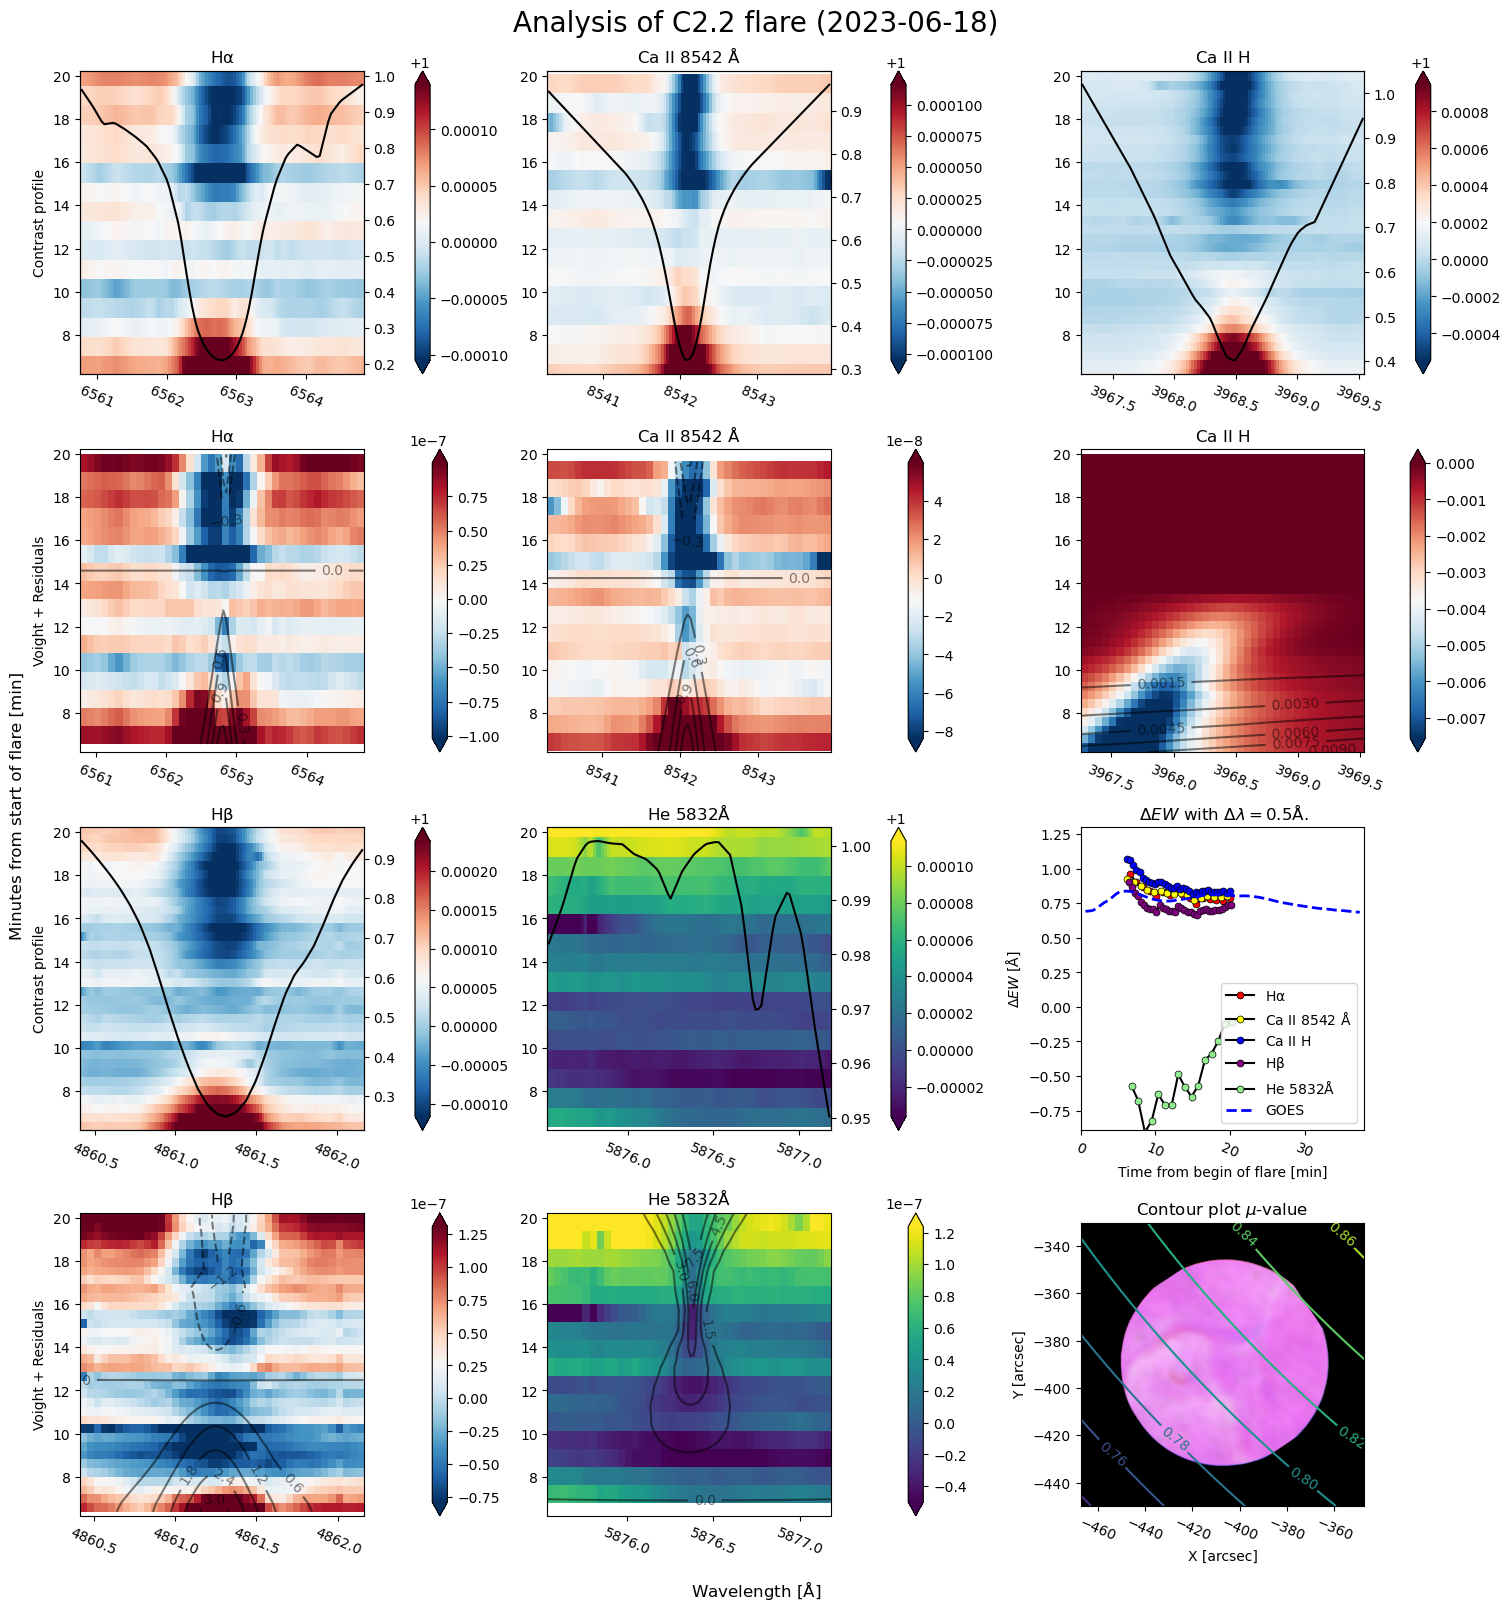

In [4]:
reload(un)
reload(un2)
# lines
lines = ["Ha23a", "CaIR23a", "CaK(2)23a", "Hbeta23a","He23a"]
# rows: the different flares
rows = 4
# collumns: the differnt lines + DEW
cols = 3
title = "Analysis of C2.2 flare (2023-06-18)"

# make figure
t = 1
fig, ax2 = plt.subplots(rows, cols, figsize=(5*t*cols,4*t*rows), constrained_layout=True)
ax = np.array([
    [*ax2[0], *ax2[2]],
    [*ax2[1], *ax2[3]]
])


fig.suptitle(title, fontsize=20)
fig.supylabel("Minutes from start of flare [min]")
fig.supxlabel(r"Wavelength [$\rm\AA$]")

ax2[2, 0].set_ylabel("Contrast profile")
ax2[3, 0].set_ylabel("Voight + Residuals")


# row 1: Scaled contrast profiles + equivalent widths
# row 2: voig residues and Mu plot

scalefactor = 1/0.3
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title)
ax[0,-1].set_ylim(-0.892439259639127, 1.3)

fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

# 2023 flare

<string>:34: SyntaxWarning: invalid escape sequence '\{'
<>:34: SyntaxWarning: invalid escape sequence '\{'
<>:34: SyntaxWarning: invalid escape sequence '\s'
<string>:34: SyntaxWarning: invalid escape sequence '\{'
<>:34: SyntaxWarning: invalid escape sequence '\{'
<>:34: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\3162072961.py:34: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\3162072961.py:34: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


[[<Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >]] [[<Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: >]]
scaled flare: Line Ha23
plotting element Ha name: Ha23
vmax = 7.26372820429164e-08, vmin = -1.9217216259270762e-08
scaled flare: Line CaIR23
plotting element CaIR name: CaIR23
vmax = 2.7759114542232175e-08, vmin = -2.8122076272299725e-08
scaled flare: Line CaK(2)23
plotting element CaK(2) name: CaK(2)23
vmax = 2.594988067917902e-07, vmin = -8.568308226367119e-08
scaled flare: Line Hbeta23
plotting element Hbeta name: Hbeta23
vmax = 7.25928034898757e-08, vmin = -2.0922716908214495e-08
scaled flare: Line He23
plotting element He name: He23
vmax = 2.36536970724093e-08, vmin = -1.0562543924600474e-08
Ha23 Bounds: 1.0431094467689646 0
CaIR23 Bounds: 1.0431094467689646 0
CaK(2)23 Bounds: 1.0431094467689646 0
Hbeta23 Bounds: 1.04567462437948 0
He23 Bounds: 1.04

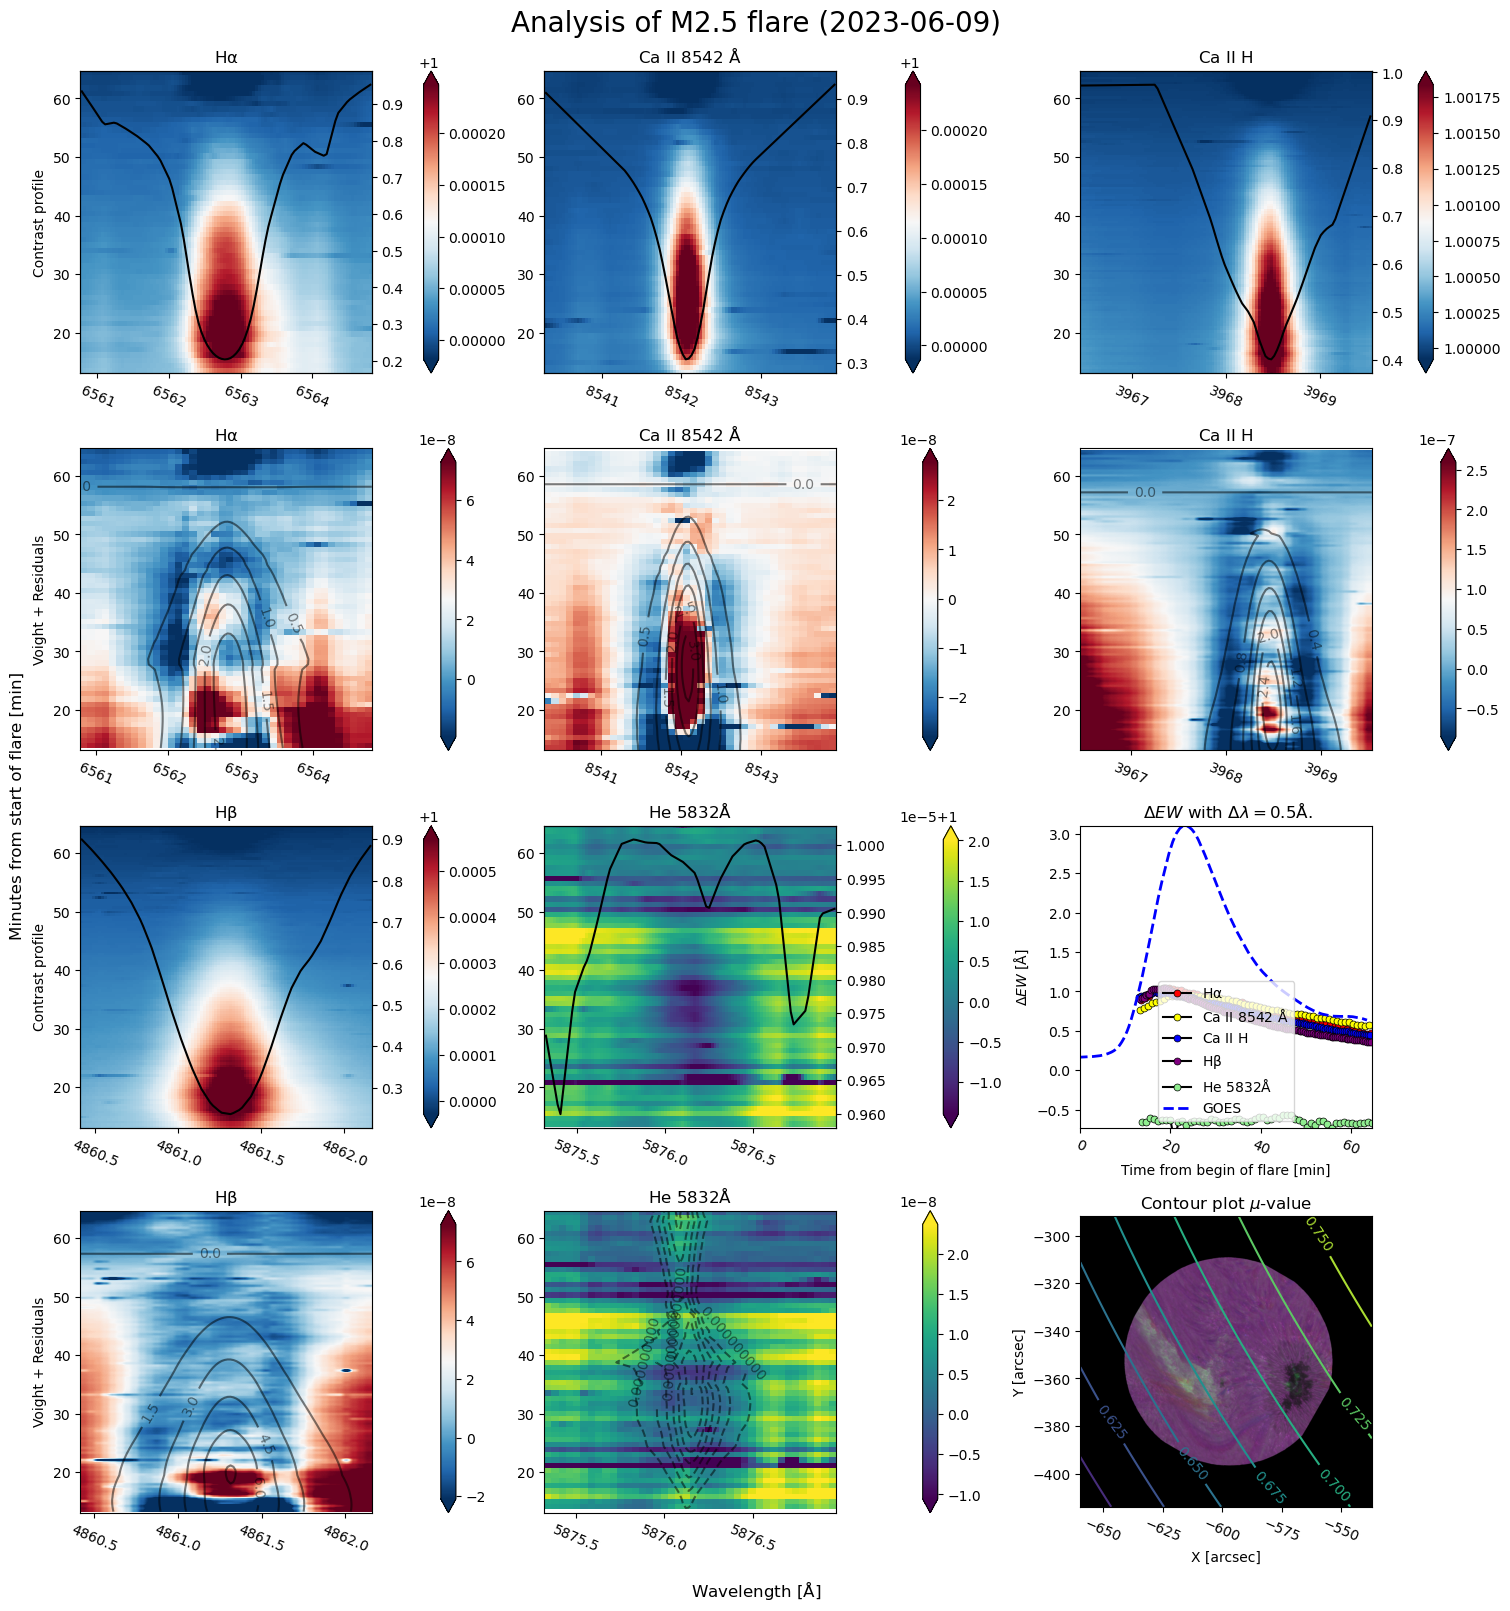

In [5]:
reload(un)
reload(un2)
# lines
lines = ["Ha23", "CaIR23", "CaK(2)23", "Hbeta23","He23"]
# rows: the different flares
rows = 4
# collumns: the differnt lines + DEW
cols = 3
title = "Analysis of M2.5 flare (2023-06-09)"

# make figure
t = 1
fig, ax2 = plt.subplots(rows, cols, figsize=(5*t*cols,4*t*rows), constrained_layout=True)
ax = np.array([
    [*ax2[0], *ax2[2]],
    [*ax2[1], *ax2[3]]
])
print(ax, ax2)
fig.suptitle(title, fontsize=20)
fig.supylabel("Minutes from start of flare [min]")
fig.supxlabel(r"Wavelength [$\rm\AA$]")

ax2[2, 0].set_ylabel("Contrast profile")
ax2[3, 0].set_ylabel("Voight + Residuals")


# row 1: Scaled contrast profiles + equivalent widths
# row 2: voig residues and Mu plot

scalefactor = 1/0.9
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title)


fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


# 2022 flare

<string>:27: SyntaxWarning: invalid escape sequence '\{'
<>:27: SyntaxWarning: invalid escape sequence '\{'
<>:27: SyntaxWarning: invalid escape sequence '\s'
<string>:27: SyntaxWarning: invalid escape sequence '\{'
<>:27: SyntaxWarning: invalid escape sequence '\{'
<>:27: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\491327382.py:27: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\491327382.py:27: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line CaIR22
plotting element CaIR name: CaIR22
vmax = 4.61516247079058e-08, vmin = -6.900491676341118e-08
CaIR22 Bounds: 0.9969130393926006 0
GOES: 2.655375625963428 0.09814851523389094 1.0305545306067527

    \begin{figure*}
        \centering
        \includegraphics[width=0.5\linewidth]{Full_analysis_plots/Analysis of M3.0 flare (2022-05-20).pdf}
        \caption{
    \textbf{The full Analysis_of_M3.0_flare_(2022-05-20):} NESSI calculated full disk profiles 
    for ~60\% flare capture. \textbf{Upper left:} 
    Contrastprofiles to the quiet sun for the lines \CaIR.
    \textbf{Lower left:} voigtprofile fits to the respective contrastprofiles above are 
    shown using a contourmap, the residues to those fitting are shown using a color map. 
    \textbf{upper right:} Differential Equivalent Width of the available lines as a function of time. 
    \textbf{Lower right:} A cocoplot of the FOV in the \CaIR line overlayed with contour 
    lines of the $\mu$-value. 
    }
 

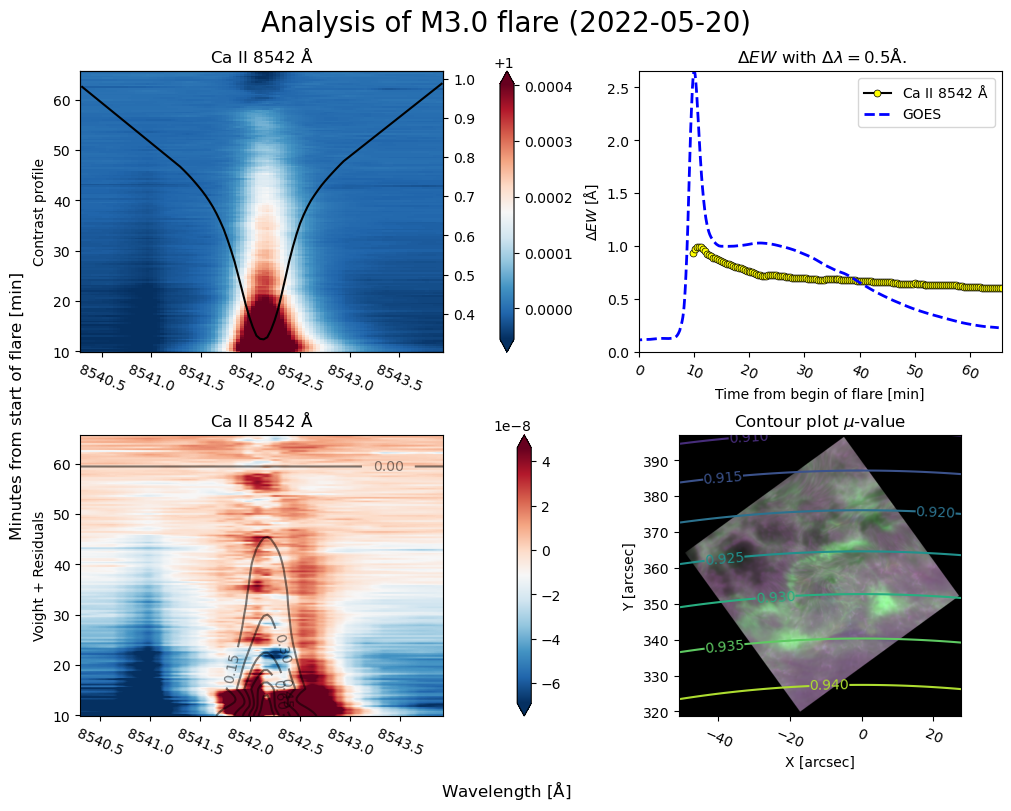

In [6]:
reload(un)
reload(un2)
# lines
lines = ["CaIR22"]
# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "Analysis of M3.0 flare (2022-05-20)"

# make figure
fig, ax = plt.subplots(rows, cols, figsize=(5*cols,4*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)
fig.supylabel("Minutes from start of flare [min]")
fig.supxlabel(r"Wavelength [$\rm\AA$]")




# row 1: Scaled contrast profiles + equivalent widths
# row 2: voig residues and Mu plot

scalefactor = 1/0.6
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title)


fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

# 2021 flare

<string>:25: SyntaxWarning: invalid escape sequence '\{'
<>:25: SyntaxWarning: invalid escape sequence '\{'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<string>:25: SyntaxWarning: invalid escape sequence '\{'
<>:25: SyntaxWarning: invalid escape sequence '\{'
<>:25: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\515621516.py:25: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\515621516.py:25: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line CaIR21
plotting element CaIR name: CaIR21
vmax = 2.9436650884951792e-08, vmin = -2.3516582728276348e-08
scaled flare: Line Fe21
Assuming that Fe21 is spectral line Fe6173.
Assuming that Fe21 is spectral line Fe6173.
plotting element Fe6173 name: Fe21
vmax = 9.805007107339204e-09, vmin = -1.9808819802453488e-08
Assuming that Fe21 is spectral line Fe6173.
CaIR21 Bounds: 1.0359104999367235 0
Assuming that Fe21 is spectral line Fe6173.
Fe21 Bounds: 1.0359104999367235 -1.0413485640334614
GOES: 1.7504378731204138 0.26637403392391135 1.396543111604405
Assuming that Fe21 is spectral line Fe6173.
Assuming that Fe21 is spectral line Fe6173.

    \begin{figure*}
        \centering
        \includegraphics[width=0.75\linewidth]{Full_analysis_plots/Analysis of C1.2 flare (2021-05-26).pdf}
        \caption{
    \textbf{The full Analysis_of_C1.2_flare_(2021-05-26):} NESSI calculated full disk profiles 
    for ~80\% flare capture. \textbf{Upper left 2:} 
    Contrastprofiles to the

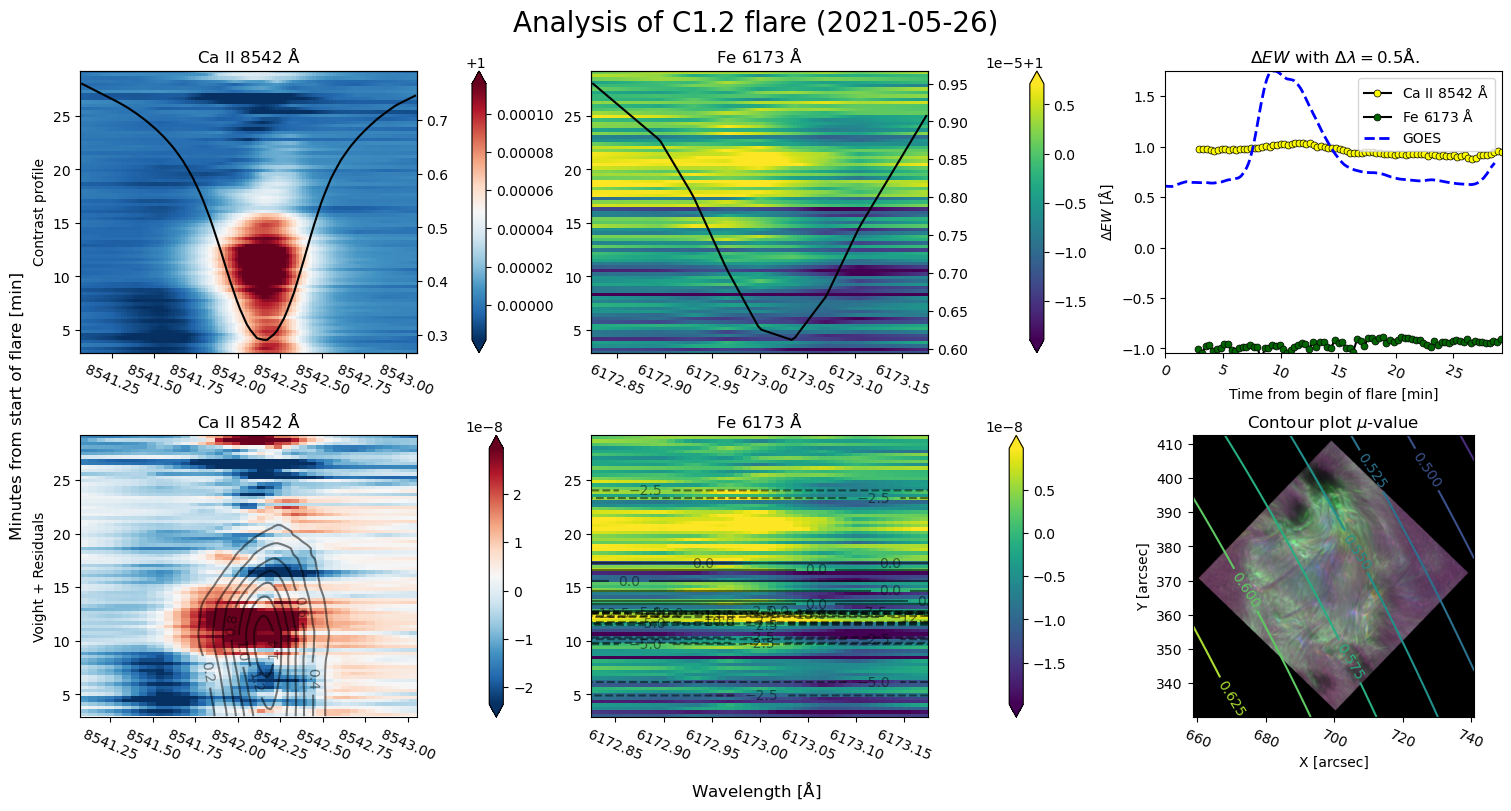

In [7]:
reload(un)
reload(un2)
# lines
lines = ["CaIR21", "Fe21"]
# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "Analysis of C1.2 flare (2021-05-26)"

# make figure
fig, ax = plt.subplots(rows, cols, figsize=(5*cols,4*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)
fig.supylabel("Minutes from start of flare [min]")
fig.supxlabel(r"Wavelength [$\rm\AA$]")


# row 1: Scaled contrast profiles + equivalent widths
# row 2: voig residues and Mu plot

scalefactor = 1/0.8
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title)


fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

# 2016 flare

<string>:27: SyntaxWarning: invalid escape sequence '\{'
<>:27: SyntaxWarning: invalid escape sequence '\{'
<>:27: SyntaxWarning: invalid escape sequence '\s'
<string>:27: SyntaxWarning: invalid escape sequence '\{'
<>:27: SyntaxWarning: invalid escape sequence '\{'
<>:27: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\2265762251.py:27: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\2265762251.py:27: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line Ha16
plotting element Ha name: Ha16
vmax = 1.647331085136858e-07, vmin = -2.8117182377486983e-07
scaled flare: Line CaIR16
plotting element CaIR name: CaIR16
vmax = 4.5640066052648946e-08, vmin = -8.872335508767632e-08
Ha16 Bounds: 0.9251953154209964 -0.024273234975350208
CaIR16 Bounds: 0.9800742717263093 -0.024273234975350208
GOES: 2.112782954101304 0.043814344106689836 1.8187911588500922

    \begin{figure*}
        \centering
        \includegraphics[width=0.75\linewidth]{Full_analysis_plots/Analysis of C8.4 flare (2016-05-14).pdf}
        \caption{
    \textbf{The full Analysis_of_C8.4_flare_(2016-05-14):} NESSI calculated full disk profiles 
    for ~70\% flare capture. \textbf{Upper left 2:} 
    Contrastprofiles to the quiet sun for the lines \Halpha and \CaIR.
    \textbf{Lower left 2:} voigtprofile fits to the respective contrastprofiles above are 
    shown using a contourmap, the residues to those fitting are shown using a color map. 
    \textbf{upper rig

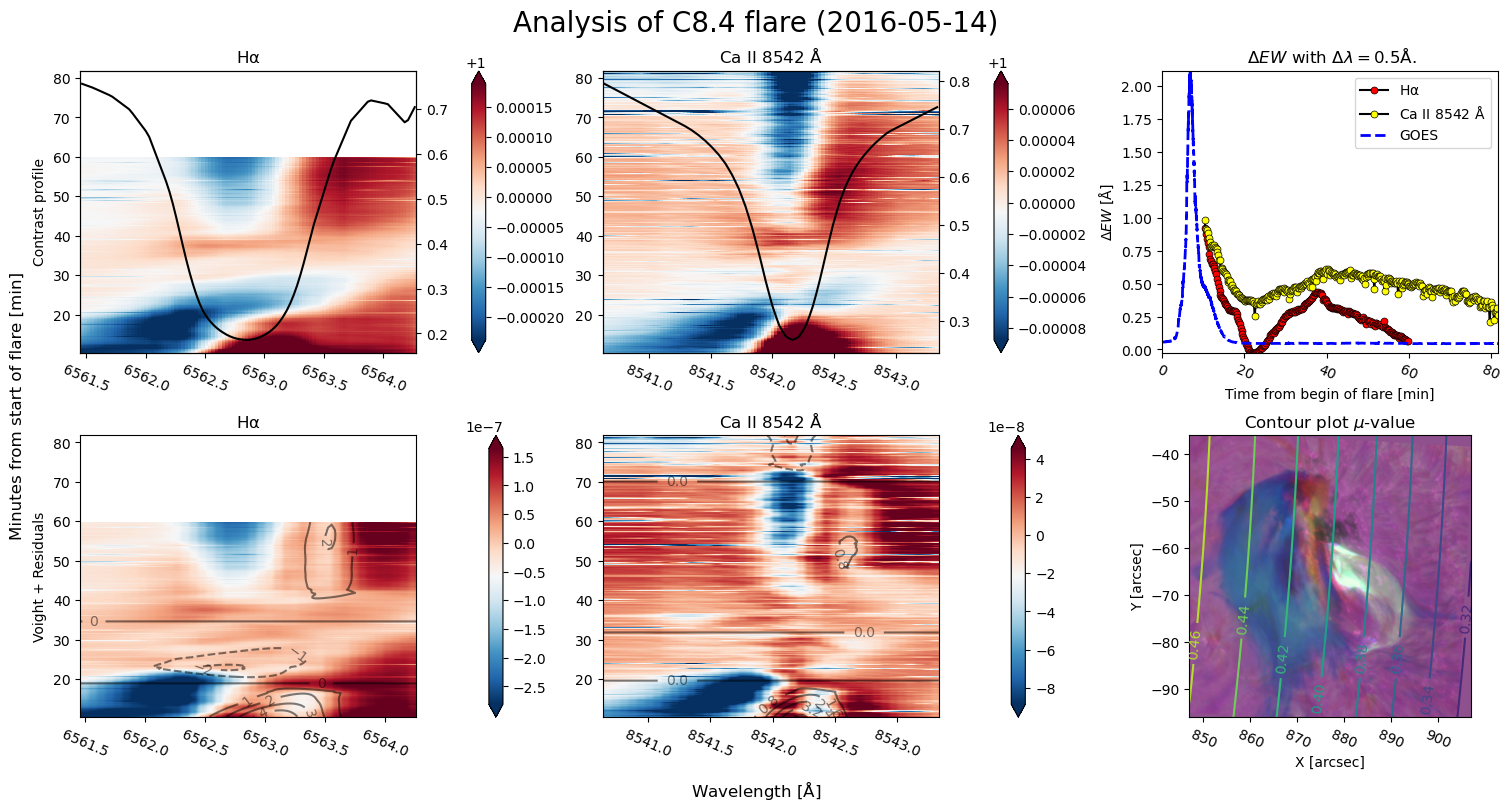

In [8]:
reload(un)
reload(un2)
# lines
lines = ["Ha16", "CaIR16"]

# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "Analysis of C8.4 flare (2016-05-14)"

# make figure
fig, ax = plt.subplots(rows, cols, figsize=(5*cols,4*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)
fig.supylabel("Minutes from start of flare [min]")
fig.supxlabel(r"Wavelength [$\rm\AA$]")



# row 1: Scaled contrast profiles + equivalent widths
# row 2: voig residues and Mu plot

scalefactor = 1/0.7
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title)


fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

# 2014 flare

<string>:26: SyntaxWarning: invalid escape sequence '\{'
<>:26: SyntaxWarning: invalid escape sequence '\{'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<string>:26: SyntaxWarning: invalid escape sequence '\{'
<>:26: SyntaxWarning: invalid escape sequence '\{'
<>:26: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\3587185198.py:26: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\3587185198.py:26: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line Ha14
plotting element Ha name: Ha14
vmax = 5.279318718632354e-07, vmin = -6.437300381238944e-07
Ha14 Bounds: 1.1053253872047843 -0.5187974338949852
GOES: 1.001889097767684 0.018508944706058936 1.0013850571549967


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\135709438.py:318: RuntimeWarning: invalid value encountered in arcsin
  return np.cos(np.arcsin(rad_dist))



    \begin{figure*}
        \centering
        \includegraphics[width=0.5\linewidth]{Full_analysis_plots/Analysis of X1.5 flare (2014-06-10).pdf}
        \caption{
    \textbf{The full Analysis_of_X1.5_flare_(2014-06-10):} NESSI calculated full disk profiles 
    for ~10\% flare capture. \textbf{Upper left:} 
    Contrastprofiles to the quiet sun for the lines \Halpha.
    \textbf{Lower left:} voigtprofile fits to the respective contrastprofiles above are 
    shown using a contourmap, the residues to those fitting are shown using a color map. 
    \textbf{upper right:} Differential Equivalent Width of the available lines as a function of time. 
    \textbf{Lower right:} A cocoplot of the FOV in the \Halpha line overlayed with contour 
    lines of the $\mu$-value. 
    }
        \label{fig:X1.5}
    \end{figure*}
    


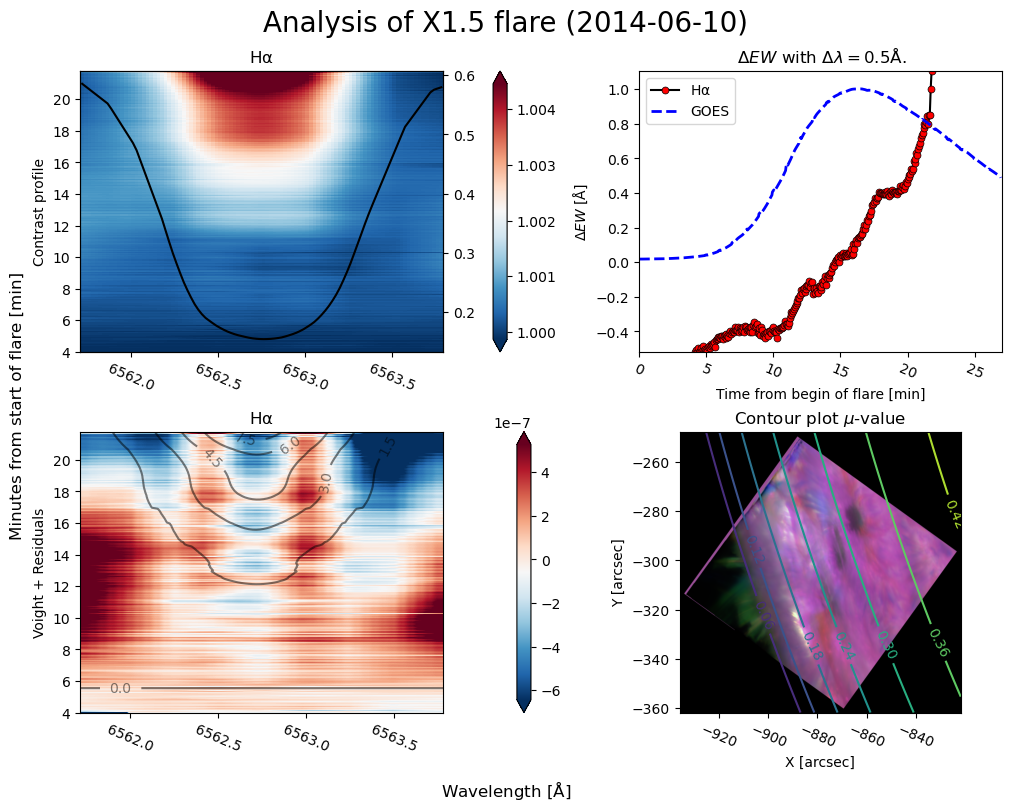

In [9]:
reload(un)
reload(un2)
# lines
lines = ["Ha14"]
# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "Analysis of X1.5 flare (2014-06-10)"

# make figure
fig, ax = plt.subplots(rows, cols, figsize=(5*cols,4*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)
fig.supylabel("Minutes from start of flare [min]")
fig.supxlabel(r"Wavelength [$\rm\AA$]")



# row 1: Scaled contrast profiles + equivalent widths
# row 2: voig residues and Mu plot
Xtra_N = 5
scalefactor = round(10,1)
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title)
Xtra_N = 1

fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

# 2015b flare

<string>:26: SyntaxWarning: invalid escape sequence '\{'
<>:26: SyntaxWarning: invalid escape sequence '\{'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<string>:26: SyntaxWarning: invalid escape sequence '\{'
<>:26: SyntaxWarning: invalid escape sequence '\{'
<>:26: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_12492\1149160879.py:26: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_12492\1149160879.py:26: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line He15b
plotting element He name: He15b
vmax = 1.9591192500880785e-07, vmin = -1.522586534785284e-07
He15b Bounds: 0 -0.9182198185581963
GOES: 1.0095886213377756 0.6637725060159718 1.0086389623524223

    \begin{figure*}
        \centering
        \includegraphics[width=0.5\linewidth]{Full_analysis_plots/Analysis_of_C3.6_flare_(2015-05-05).pdf}
        \caption{
    \textbf{The full Analysis of C3.6 flare (2015-05-05):} NESSI calculated full disk profiles 
    for ~20\% flare capture. \textbf{Upper left:} 
    Contrastprofiles to the quiet sun for the lines \He5832.
    \textbf{Lower left:} voigtprofile fits to the respective contrastprofiles above are 
    shown using a contourmap, the residues to those fitting are shown using a color map. NESSI clv profiles where not available for \He5832.             The quiet sun profiles are used as FOV and an Atlas is used for saas profile.                For clarity these lines are collered differntly.
    \textbf{upper right:} 

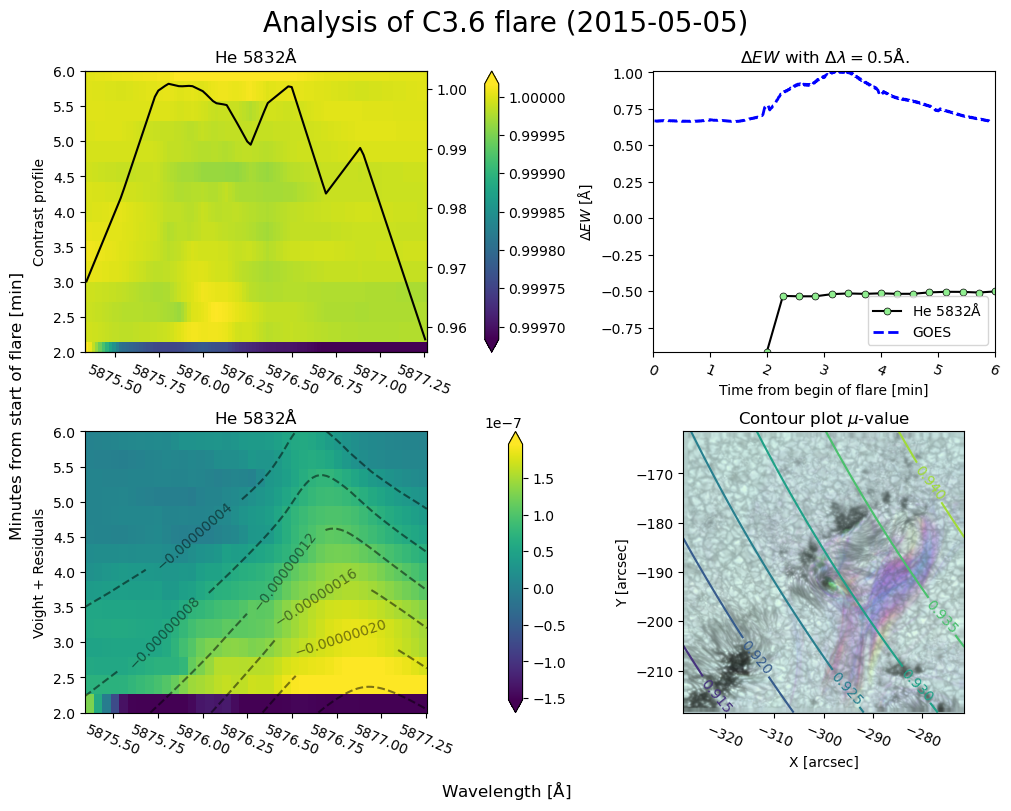

In [5]:
reload(un)
reload(un2)
# lines
lines = ["He15b"]
# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "Analysis of C3.6 flare (2015-05-05)"

# make figure
fig, ax = plt.subplots(rows, cols, figsize=(5*cols,4*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)
fig.supylabel("Minutes from start of flare [min]")
fig.supxlabel(r"Wavelength [$\rm\AA$]")



# row 1: Scaled contrast profiles + equivalent widths
# row 2: voig residues and Mu plot
Xtra_N = 10
scalefactor = 1/0.15
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title)
Xtra_N = 1

fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

# C2.2

<string>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<string>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\1818505662.py:30: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\1818505662.py:30: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line CaIR19
plotting element CaIR name: CaIR19
the special flare
vmax = 1.6068648677205643e-07, vmin = -5.37583744360938e-08
scaled flare: Line Fe6173_2019
plotting element Fe6173 name: Fe6173_2019
the special flare
vmax = 1.818411513666525e-08, vmin = -1.4930233909322424e-08
scaled flare: Line CaK19
plotting element CaK name: CaK19
the special flare
vmax = 2.5712196119210393e-07, vmin = -8.94649117219598e-08
CaIR19 Bounds: 1.1134162384287116 0
Fe6173_2019 Bounds: 1.1134162384287116 -0.9618791933746855
CaK19 Bounds: 1.1134162384287116 -0.9618791933746855
GOES: 7.068092210960935 0.06021741157626457 1.3291630285780172

    \begin{figure*}
        \centering
        \includegraphics[width=1.0\linewidth]{Full_analysis_plots/Analysis of C2.0 flare (2019-05-06).pdf}
        \caption{
    \textbf{The full Analysis_of_C2.0_flare_(2019-05-06):} NESSI calculated full disk profiles 
    for ~91\% flare capture. \textbf{Upper left 3:} 
    Contrastprofiles to the quiet sun for the li

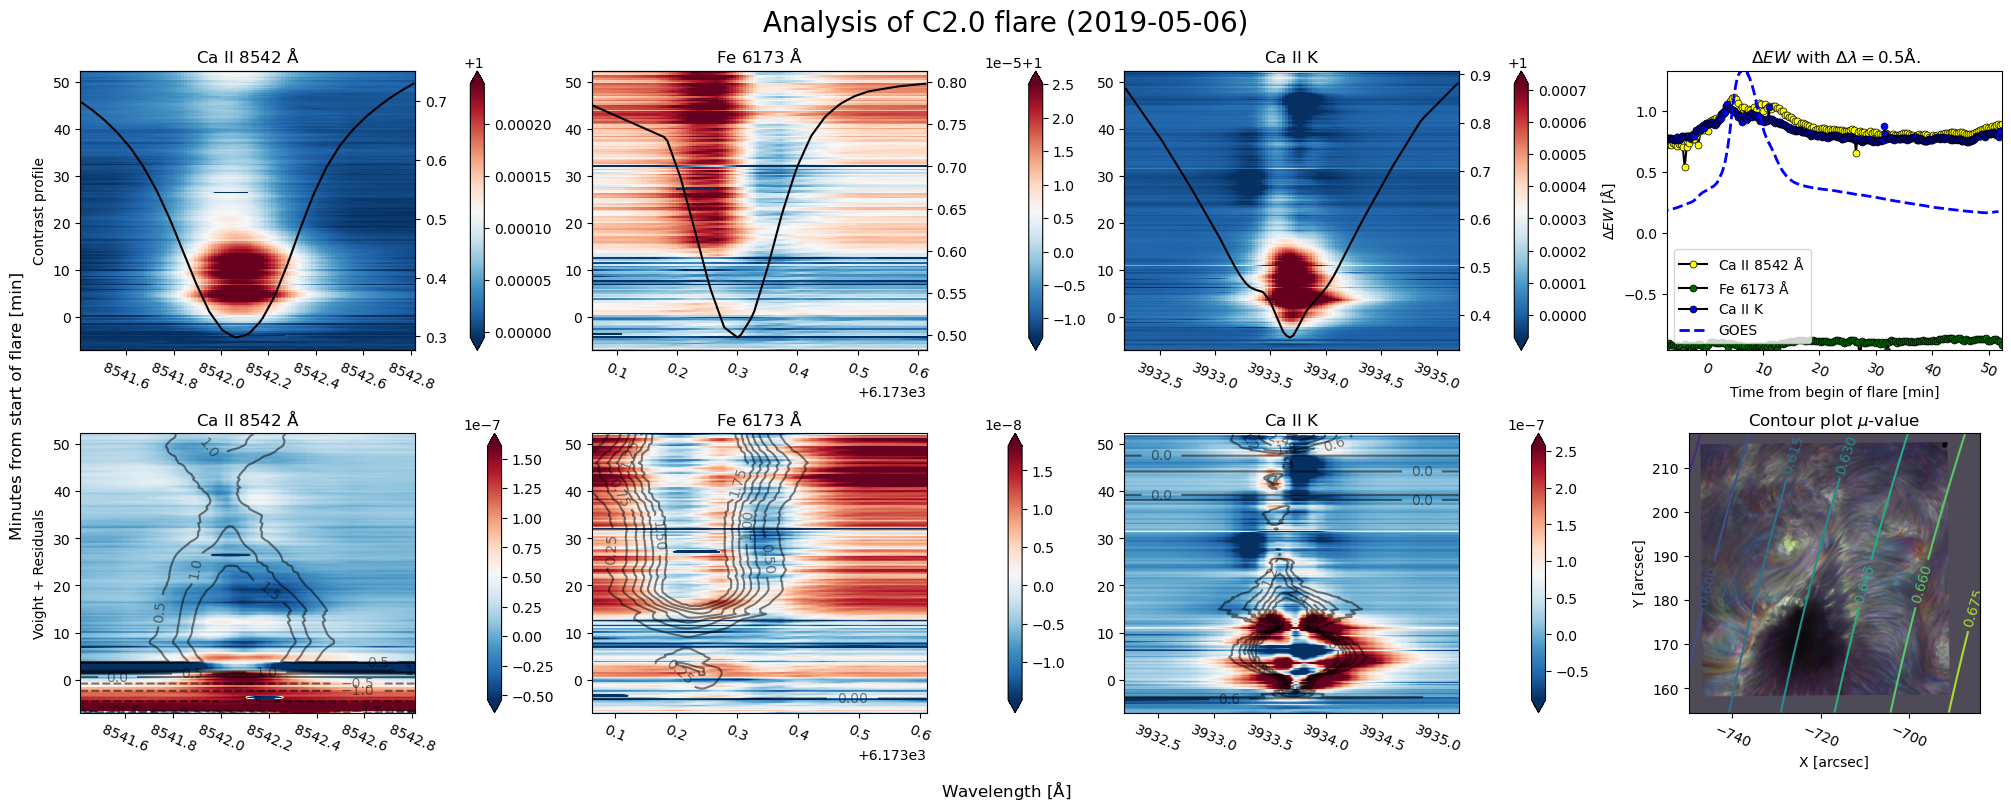

In [10]:
# lines
lines = ["CaIR19", "Fe6173_2019", "CaK19"]
qs_sub = [False, False, False]

# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "Analysis of C2.0 flare (2019-05-06)"

# make figure
fig, ax = plt.subplots(rows, cols, figsize=(5*cols,4*rows), constrained_layout=True)
# plt.xticks(rotation=70)
plt.tick_params(axis='x', which='major', rotation=-70)  
fig.suptitle(title, fontsize=20)
fig.supylabel(f"Minutes from start of flare [min]")
fig.supxlabel(r"Wavelength [$\rm\AA$]")



# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigt residues and Mu plot

scalefactor = round(1/0.9,1) 
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title)
ax[0,-1].set_ylim(-0.9618791933746855, 1.33)



fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


# M1.1 Flare 

<string>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<string>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\1218204121.py:30: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\1218204121.py:30: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


dict_keys(['area_theta_Ha14a', 'FOV_Ha14a', 'quiet_sun_Ha14a', 'nessi_Ha14a', 'True_nessi_Ha14a', 'TIME_Ha14a', 'area_theta_CaIR14a', 'FOV_CaIR14a', 'quiet_sun_CaIR14a', 'nessi_CaIR14a', 'True_nessi_CaIR14a', 'TIME_CaIR14a'])
scaled flare: Line Ha14a
plotting element Ha name: Ha14a
vmax = 6.083072881085497e-07, vmin = -9.43676499635892e-10
scaled flare: Line CaIR14a
plotting element CaIR name: CaIR14a
vmax = 5.41194717787383e-07, vmin = -1.2044024593905143e-07
Ha14a Bounds: 0.9459742176961183 0
CaIR14a Bounds: 0.9523622217715582 0
GOES: 1.0235643367083722 0.07766255642196546 1.018629124932845

    \begin{figure*}
        \centering
        \includegraphics[width=0.75\linewidth]{Full_analysis_plots/Analysis of M1.1 flare (2014-09-06).pdf}
        \caption{
    \textbf{The full Analysis_of_M1.1_flare_(2014-09-06):} NESSI calculated full disk profiles 
    for ~25\% flare capture. \textbf{Upper left 2:} 
    Contrastprofiles to the quiet sun for the lines \Halpha and \CaIR.
    \textbf{Lo

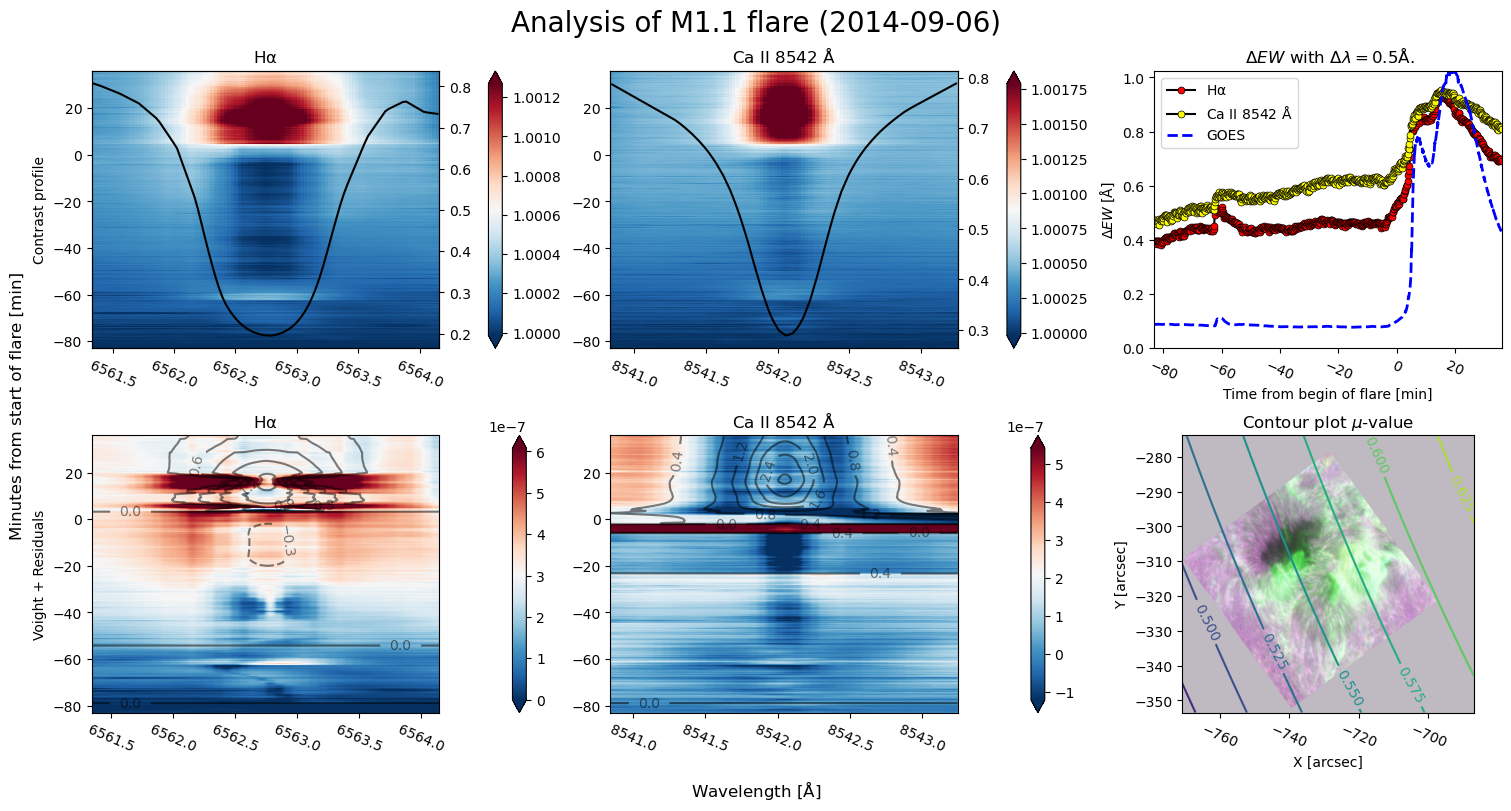

In [11]:
reload(un)
reload(un2)
lines = ["Ha14a", "CaIR14a"]

data = un.load_for_further_analysis(lines, full_path = "E:/solar flares/data/2014-09-06/")
print(data.keys())


# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "Analysis of M1.1 flare (2014-09-06)"

# make figure
fig, ax = plt.subplots(rows, cols, figsize=(5*cols,4*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)
fig.supylabel("Minutes from start of flare [min]")
fig.supxlabel(r"Wavelength [$\rm\AA$]")



# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigtresidues and Mu plot

scalefactor = round(4,1)
Full_line_ana(fig, ax, lines, scalefactor, data=data, name_of_flare=title, name_of_show_line="CaIR14a")


fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

# C1.7 Flare

<string>:33: SyntaxWarning: invalid escape sequence '\{'
<>:33: SyntaxWarning: invalid escape sequence '\{'
<>:33: SyntaxWarning: invalid escape sequence '\s'
<string>:33: SyntaxWarning: invalid escape sequence '\{'
<>:33: SyntaxWarning: invalid escape sequence '\{'
<>:33: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\490360101.py:33: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\490360101.py:33: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


dict_keys(['area_theta_Hbeta17a', 'FOV_Hbeta17a', 'quiet_sun_Hbeta17a', 'nessi_Hbeta17a', 'True_nessi_Hbeta17a', 'TIME_Hbeta17a', 'area_theta_CaIR17a', 'FOV_CaIR17a', 'quiet_sun_CaIR17a', 'nessi_CaIR17a', 'True_nessi_CaIR17a', 'TIME_CaIR17a'])
scaled flare: Line Hbeta17a
plotting element Hbeta name: Hbeta17a
vmax = 9.625500553954595e-08, vmin = -9.673630602872106e-08
scaled flare: Line CaIR17a
plotting element CaIR name: CaIR17a
vmax = 4.518707245932419e-07, vmin = -2.2146205617112339e-07
Hbeta17a Bounds: 0 -1.0227626538179757
CaIR17a Bounds: 0 -1.0242116983783434
GOES: 1.0370604542279682 0.002262813006492083 1.027798435691752

    \begin{figure*}
        \centering
        \includegraphics[width=0.75\linewidth]{Full_analysis_plots/Analysis of X8.2 flare (2017-09-10).pdf}
        \caption{
    \textbf{The full Analysis_of_X8.2_flare_(2017-09-10):} NESSI calculated full disk profiles 
    for ~83\% flare capture. \textbf{Upper left 2:} 
    Contrastprofiles to the quiet sun for the line

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\135709438.py:318: RuntimeWarning: invalid value encountered in arcsin
  return np.cos(np.arcsin(rad_dist))


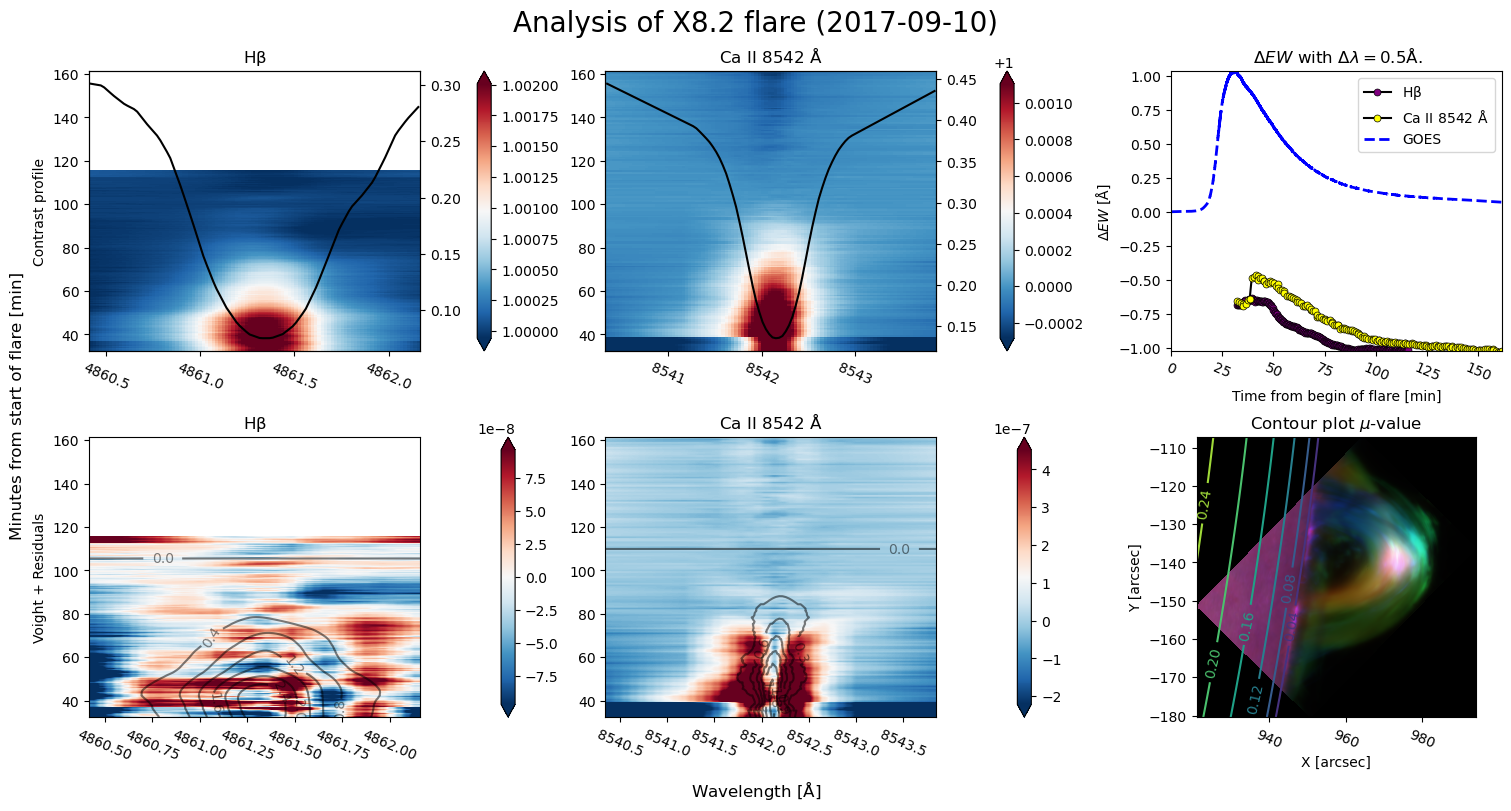

In [12]:
reload(un)
reload(un2)
lines = ["Hbeta17a", "CaIR17a"] #], "CaK17a"]

data = un.load_for_further_analysis(lines, full_path = "E:/solar flares/data/2017-09-10/")
print(data.keys())
# un2.disgard_cont_point("CaK17a", data)
# un2.split_data_in_two_lines("CaK17a", data, 3950, lines)




# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "Analysis of X8.2 flare (2017-09-10)"

# make figure
fig, ax = plt.subplots(rows, cols, figsize=(5*cols,4*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)
fig.supylabel("Minutes from start of flare [min]")
fig.supxlabel(r"Wavelength [$\rm\AA$]")


# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigt residues and Mu plot

scalefactor = round(1/0.8,1)
Full_line_ana(fig, ax, lines, scalefactor, data=data, name_of_flare=title)


fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

# Analysis of X9.3 flare

<string>:23: SyntaxWarning: invalid escape sequence '\{'
<>:23: SyntaxWarning: invalid escape sequence '\{'
<>:23: SyntaxWarning: invalid escape sequence '\s'
<string>:23: SyntaxWarning: invalid escape sequence '\{'
<>:23: SyntaxWarning: invalid escape sequence '\{'
<>:23: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\3245330152.py:23: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\3245330152.py:23: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line Ha17
plotting element Ha name: Ha17
vmax = 5.963651425180233e-07, vmin = -1.2780474099110317e-07
scaled flare: Line CaK17
plotting element CaK name: CaK17
vmax = 5.994900871076024e-07, vmin = -6.452313088675267e-07
scaled flare: Line CaII17
plotting element CaIR name: CaII17
vmax = 1.9188588804781275e-06, vmin = -7.052854899007385e-08
Ha17 Bounds: 0.9775802878524896 0
CaK17 Bounds: 1.0303545321862937 0
CaII17 Bounds: 1.0501337279349894 0
GOES: 1.0599785825450139 0.011080854917673778 1.039896821981799

    \begin{figure*}
        \centering
        \includegraphics[width=1.0\linewidth]{Full_analysis_plots/Analysis of X9.3 flare (2017-09-06).pdf}
        \caption{
    \textbf{The full Analysis_of_X9.3_flare_(2017-09-06):} NESSI calculated full disk profiles 
    for ~40\% flare capture. \textbf{Upper left 3:} 
    Contrastprofiles to the quiet sun for the lines \Halpha, \CaK and \CaIR.
    \textbf{Lower left 3:} voigtprofile fits to the respective contrastprofiles abov

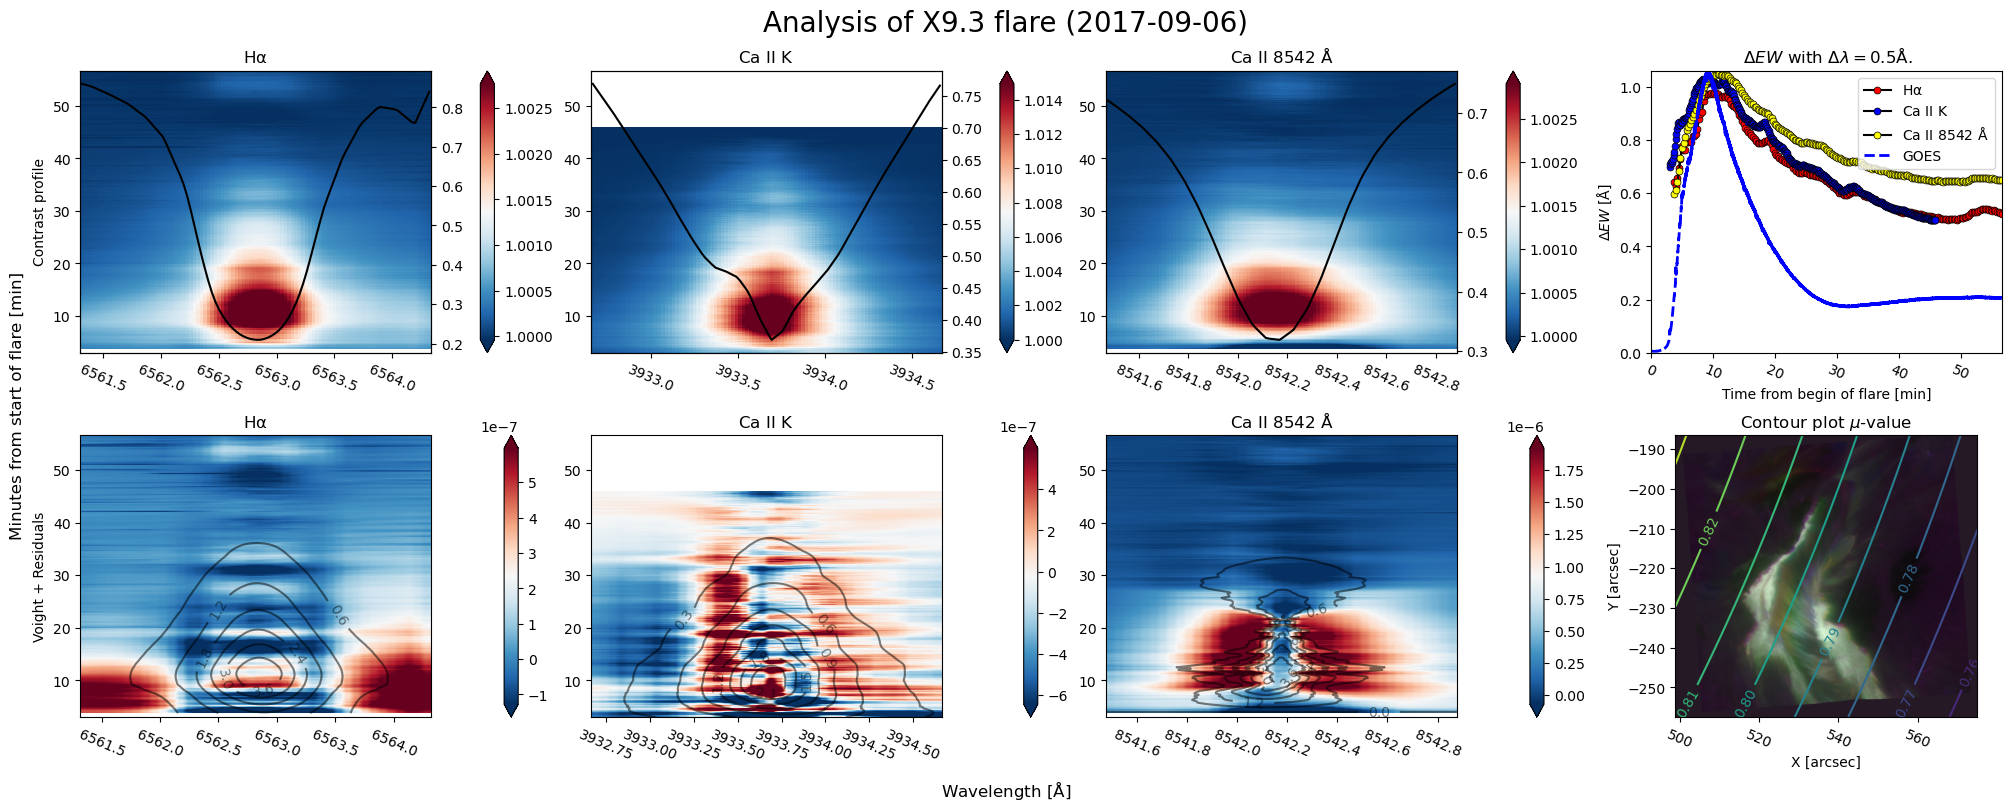

In [13]:

# lines
lines = ["Ha17", "CaK17", "CaII17"]

# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "Analysis of X9.3 flare (2017-09-06)"

# make figure
fig, ax = plt.subplots(rows, cols, figsize=(5*cols,4*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)
fig.supylabel("Minutes from start of flare [min]")
fig.supxlabel(r"Wavelength [$\rm\AA$]")

# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigt residues and Mu plot

scalefactor = round(5/2,1)
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title)


fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

**Figure Description**: \textbf{The full Analysis of the X9.3 flare:} NESSI calculated full disk profiles for ~40% flare capture. \textbf{Upper left 3:} Contrastprofiles to the quiet sun for the lines \Halpha, \CaK and \CaIR. \textbf{Lower left 3:} voigt profile fits to the respective contrastprofiles above are shown using a contourmap, the residues to those fitting are shown using a color map. \textbf{upper right:} Differential Equivalent Width of the available lines as a function of time. \textbf{Lower right:} A cocoplot of the FOV in the \Halpha line overlayed with contour lines of the $\mu$-value. 

Full analysis of the X9.3 flare. For the Available lines \Halpha, \CaIR and \CaK the three discussed methods of analysis are applied: NESSI generate virtual full disc spectum shown in the upper row, voigt fit and residue




**In text notice**: For the X9.3 the flare analysis we have preformed is plotted in \autoref{}. 
Here the full disk profiles are calculated by NESSI for the 3 availble lines \Halpha, \CaK and \CaIR and shown in the upper tree contrast profiles. The FOV of the SST captured 
approximately 40% of the flare area so we scaled by 
The difference to quiet spectrum normalized is displayed so a 0.15% increase in \Halpha, 1.5% increase in \CaK and 0.4% increase in \CaIR is found mostely in the line center.
It appears that the width of the broadening is comparable to the line width. We fitted this intensity increase with a voigt profile and in the lower 3 maps the shape of the 
voigt profiles is shown with contour lines.  By the voigt countour lines the peak of and the decrease after the flare even more clear than in the displays above.  The residues of this fitting are plotted in the same plots with a color map, which showing the intensity with pure thermal increase subtracted. In this way the telluric in \Halpha is a prominent feature and a slightly increasing absorption in the left wing after the flare can be observed as wel (\textbf{What does this mean?}).
In \CaK we observe a rather strong change in absorption and emission in the line center, which might be caused by the line shape of \CaK. Other features are an increasing absorption in the left wing analogous to \Halpha and the slowly decaying emmission in the right wing, which might be a sign of coronal rain?????? In \CaIR the horizontal oddity of voigt fits and residues is not caused by misfitting but is truely caused by the flare. Although the fit is at the start of the flare is somewhat more uncertain the shape of the voigt profiles are quiet consistent in time and thus the rather strong increase in the right wing and left center are by the nature of the flare. The minor features from \CaK are here observed as well: an increasing absorption in the left wing and the slowly decaying emmission in the right wing. For the differential equivalent width (DEW) are plotted in the rigth upper corner and are a measure of the increase of intensity as shown before by \citet{Otsu}. The 3 lines beheave similar during the evolution in their respective DEW where we see a peak around 5 minutes followed by a slowing decay. 

In [14]:
# saving this data for collaboration
def saving_Full_line_ana(names_of_lines_list, scalefactor, name_of_flare="X9.3"):
    data = get_data(names_of_lines_list)
    for name in names_of_lines_list:
        wav, DFD , time, line, std = un2.contrast_FD_data(name,data, quiet_sun_subtraction=False, area_factor=area_factor*scalefactor, normal=True, add_noise=False)
        print(np.shape(wav))
        params, voigt, res = load_voigt_data(name, wav)
        c = area_factor*scalefactor
        
        filename = f"data/data_{name}_{name_of_flare}_voigt_residue_analysis.npz"

        np.savez(filename, time, wav, DFD, std, c*params, c*res)
        
        

# lines
lines = ["Ha17", "CaK17", "CaII17"]
flare_name = "X9.3"
scalefactor = round(5/2,1)

# saving_Full_line_ana(lines, scalefactor, name_of_flare=flare_name)

data_structure = """
Discription of "data_{name}_{name_of_flare}_voigtresidue_analysis.npz" file:
arr_0:  time        time in minutes from the start of the flare (as in solar monitor or tabel below.)
arr_1:  wav         wavelength positions in angstrom
arr_2:  DFD         Difference intencity for Full Disk synthesized spectrum compared to quiet full disk spectrum (time x wav- array)
arr_3:  std         Standard deviation in spectral position for DFD (wav - array)
arr_4:  params      voig fit parameters in time. the 4 parameters are amplitude, center, sigma, gamma. See below for implementation (time x 4 -array)
arr_5:  res         Residues to the voigt fit in time. (time x wav - array)


def gaussian(x, amp_g, cen_g, sigma_g):
    # Gaussian function.
    return amp_g * np.exp(-(x - cen_g)**2 / (2 * sigma_g**2))

def lorentzian(x, amp_l, cen_l, gamma_l):
    # Lorentzian function.
    return amp_l * (gamma_l**2 / ((x - cen_l)**2 + gamma_l**2))

def voigt(x, param, offset=0):
    # Voigt profile: approximation by combining Gaussian and Lorentzian.
    amp_v, cen_v, sigma_v, gamma_v = param
    f_g = sigma_v**2 / (sigma_v**2 + gamma_v**2)
    return (f_g * gaussian(x, 1, cen_v, sigma_v) +
            (1 - f_g) * lorentzian(x, 1, cen_v, gamma_v)) * amp_v + offset
            
            
\\begin{table*}[ht]
    \centering
    \caption{Flare Information}
    \label{tab:flare_info} 
    \\begin{tabular}{llllllllll}
        \\toprule
        Year & NOAA & Class & Start/Stop/Peak & SST Start/Stop & Overlap & (X, Y) & $\mu$ & Lines & Cad [s] \\
        \midrule
        2017-09-06 &  12673 & X9.3 &11:53/12:10/12:01 &11:56/12:52 & appr 40\% & (513'', -216'') & 0.815 & \CaIR & 15.0 \\ & & & & & & & & \Halpha & 15.0  \\ & & & & & & & & \CaK & 6.6 \\
        2017-09-06 & 12673 & X2.2 & 8:57/9:17/09:09 &09:04/09:54 & appr 60\% & (542'', -208'') & 0.803 & \CaIR & 15.0 \\ & & & & & & & & \Halpha & 15.0 \\ & & & & & & & & \CaK & 6.6 \\ 
        2015-06-24 &  12371 & C5.6&	15:12/15:40/15:29 &-/- &  & (496'', 175'') &  & \CaIR & 15.0 \\ & & & & & & & & \Halpha & 15.0  \\
        2011-08-06 &  	11267 & C4.1 &08:37/08:51/08:47 &-/- & appr 40\% & (S17 E12) & 0.815 & \CaIR & 15.0 \\ & & & & & & & & \Halpha & 15.0  \\ & & & & & & & & \CaK & 6.6 \\
        2019-05-06 &12740 & C2.0  &08:41/08:51/08:47 &08:34/09:33&&(-716.9'', 186.2'')& 0.638 & \Fe6173 & 20.9 \\ & & & & & & & & \CaIR  & 20.9\\ & & & & & & & & \CaK & 7.8 \\ 
        2013-06-30 & 11778 & C1.5 &09:11/09:27/09:18 &09:16/10:17&100\%&(323.4'', -287.9'')& 0.892 & \Halpha        & 7.3  \\
        \\bottomrule
    \end{tabular}
\end{table*}
"""



# Open the file in write mode ('w') and write content
with open("data/data_description.txt", "w") as file:
  file.write(data_structure)

print("Text file saved successfully!")



Text file saved successfully!


<>:23: SyntaxWarning: invalid escape sequence '\c'
<>:23: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\3994107321.py:23: SyntaxWarning: invalid escape sequence '\c'
  data_structure = """


# X2.2 flare 

<string>:24: SyntaxWarning: invalid escape sequence '\{'
<>:24: SyntaxWarning: invalid escape sequence '\{'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<string>:24: SyntaxWarning: invalid escape sequence '\{'
<>:24: SyntaxWarning: invalid escape sequence '\{'
<>:24: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\4053226201.py:24: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_20080\4053226201.py:24: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line Ha17_9u
plotting element Ha name: Ha17_9u
vmax = 1.3758604402299049e-07, vmin = -1.1039163494489855e-07
Ha17_9u Bounds: 0.9849694276132123 0
GOES: 1.0355646713766111 0.020297999136664486 1.0273647458830604

    \begin{figure*}
        \centering
        \includegraphics[width=0.5\linewidth]{Full_analysis_plots/Analysis of X2.2 flare (2017-09-06).pdf}
        \caption{
    \textbf{The full Analysis_of_X2.2_flare_(2017-09-06):} NESSI calculated full disk profiles 
    for ~59\% flare capture. \textbf{Upper left:} 
    Contrastprofiles to the quiet sun for the lines \Halpha.
    \textbf{Lower left:} voigtprofile fits to the respective contrastprofiles above are 
    shown using a contourmap, the residues to those fitting are shown using a color map. 
    \textbf{upper right:} Differential Equivalent Width of the available lines as a function of time. 
    \textbf{Lower right:} A cocoplot of the FOV in the \Halpha line overlayed with contour 
    lines of the $\mu$-value

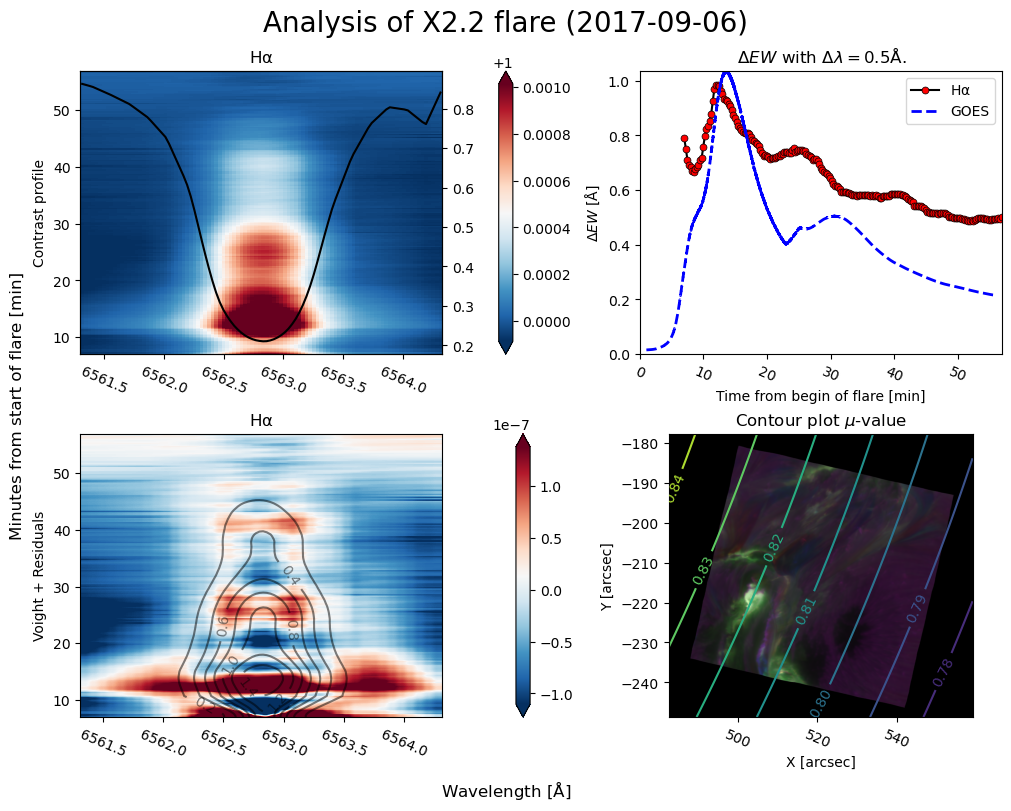

In [15]:
# lines
lines = ["Ha17_9u"]

# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "Analysis of X2.2 flare (2017-09-06)"

# make figure
fig, ax = plt.subplots(rows, cols, figsize=(5*cols,4*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)
fig.supylabel(f"Minutes from start of flare [min]")
fig.supxlabel(r"Wavelength [$\rm\AA$]")

# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigtresidues and Mu plot

Xtra_N=20
scalefactor = round(1/0.6,1)
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title)
Xtra_N=1

fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

**Figure Description**: \textbf{The full Analysis of the X2.2 flare:} NESSI calculated full disk profiles for ~60% flare capture. \textbf{Upper left:} Contrastprofiles to the quiet sun for the available line \Halpha. \textbf{Lower left:} voigt profile fits to the respective contrastprofiles above are shown using a contourmap, the residues to those fitting are shown using a color map. \textbf{upper right:} Differential Equivalent Width of the available lines as a function of time. \textbf{Lower right:} A cocoplot of the FOV in the \Halpha line at the start of the flare overlayed with contour lines of the $\mu$-value. 



**In text notice**: For the X2.2 the full flare analysis is plotted in \autoref{} in the same way as was done for the X9.3 flare, assuming $60\%$ capture of the flare. 
The only line \Halpha encountered an increase of $0.05\%$. The contrast plots show a smooth decay of the inensity with a bit of variance in the left wing. In general the wings are quiet strong in absorption. The DEW experience a sharp dip before the start of the flare. The maxima in the DEW are matched with the stronger emmission profiles in the contrast profiles in the top left plot and the contourlines underneath. The telluric is again present. 

# C1.5

<string>:23: SyntaxWarning: invalid escape sequence '\{'
<>:23: SyntaxWarning: invalid escape sequence '\{'
<>:23: SyntaxWarning: invalid escape sequence '\s'
<string>:23: SyntaxWarning: invalid escape sequence '\{'
<>:23: SyntaxWarning: invalid escape sequence '\{'
<>:23: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_9332\30548773.py:23: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_9332\30548773.py:23: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line Ha13
plotting element Ha name: Ha13
vmax = 3.7584911925103613e-08, vmin = -1.1853539537468827e-07
Ha13 Bounds: 1.0993211069384887 -0.2302781970256911
GOES: 1.0051471049299074 0.28505665034494576 1.0038778285975662

    \begin{figure*}
        \centering
        \includegraphics[width=0.5\linewidth]{Full_analysis_plots/Analysis_of_C1.5_flare_(2013-06-30).pdf}
        \caption{
    \textbf{The full Analysis of C1.5 flare (2013-06-30):} NESSI calculated full disk profiles 
    for ~100\% flare capture. \textbf{Upper left:} 
    Contrastprofiles to the quiet sun for the lines \Halpha.
    \textbf{Lower left:} voigtprofile fits to the respective contrastprofiles above are 
    shown using a contourmap, the residues to those fitting are shown using a color map. 
    \textbf{upper right:} Differential Equivalent Width of the available lines as a function of time. 
    \textbf{Lower right:} A cocoplot of the FOV in the \Halpha line overlayed with contour 
    lines of the $\

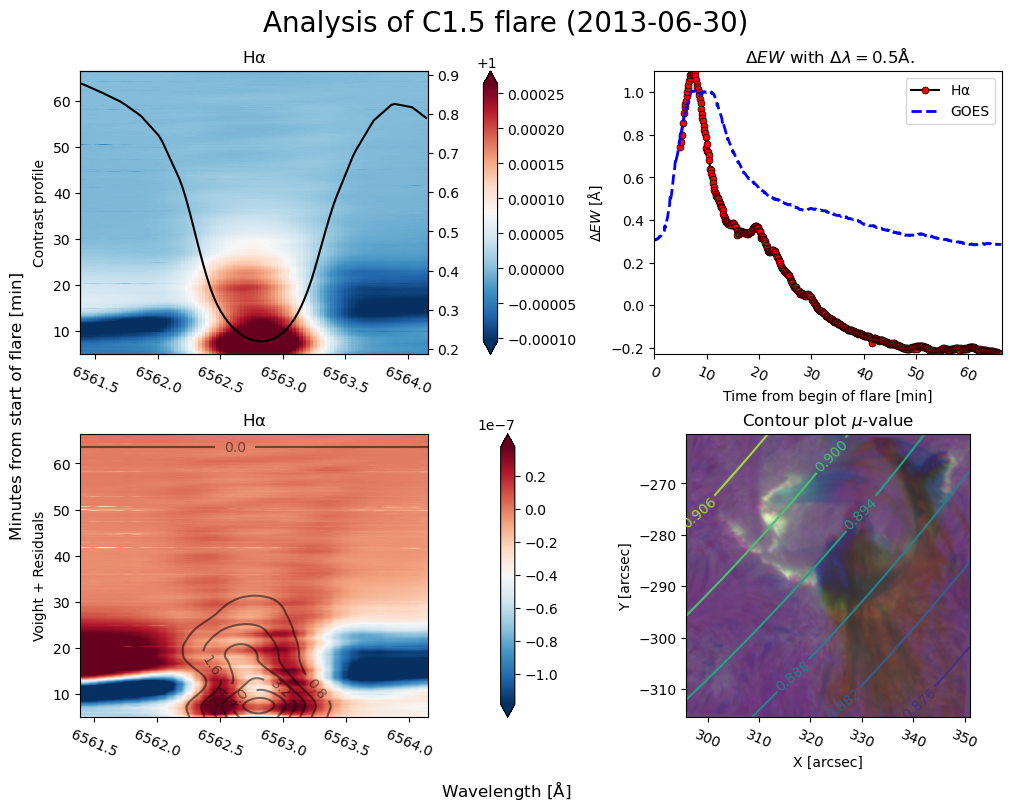

In [7]:
# lines
lines = ["Ha13"]

# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "Analysis of C1.5 flare (2013-06-30)"

# make figure
fig, ax = plt.subplots(rows, cols, figsize=(5*cols,4*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)
fig.supylabel(f"Minutes from start of flare [min]")
fig.supxlabel(r"Wavelength [$\rm\AA$]")

# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigtresidues and Mu plot

scalefactor = round(1,1)
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title)


fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

**Figure Description**: \textbf{The full Analysis of the C1.5 flare:} NESSI calculated full disk profiles for assumed full flare capture. \textbf{Upper left:} Contrastprofiles to the quiet sun for the lines \Halpha. \textbf{Lower left:} voigt profile fits to the respective contrastprofiles above are shown using a contourmap, the residues to those fitting are shown using a color map. \textbf{upper right:} Differential Equivalent Width of the available lines as a function of time. \textbf{Lower right:} A cocoplot of the FOV in the \Halpha line at the start of the flare overlayed with contour lines of the $\mu$-value. 


**In text notice**: For the C1.5 full capture of the flare is assumed. The full flare analysis is plotted in \autoref{} in the same way as was done for the previous flares.
The only available line \Halpha encountered an increase of $0.0001\%$. The contrast plots show a smooth and assymetric wiggling decay of the inensity. at 20 minutes into the flare the assymmetry is the stronges which has its cause in the amount of material ejected and hanging in the frame . 


# M1.9 Flare

<string>:24: SyntaxWarning: invalid escape sequence '\{'
<>:24: SyntaxWarning: invalid escape sequence '\{'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<string>:24: SyntaxWarning: invalid escape sequence '\{'
<>:24: SyntaxWarning: invalid escape sequence '\{'
<>:24: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_9332\1961769251.py:24: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_9332\1961769251.py:24: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line Ha15a
plotting element Ha name: Ha15a
vmax = 2.2276224338899403e-07, vmin = -8.92132522223781e-08
scaled flare: Line CaIR15a
plotting element CaIR name: CaIR15a
vmax = 9.118052610092694e-08, vmin = -4.490324647507379e-08
Ha15a Bounds: 0.027869111462935896 -0.9914528612001379
CaIR15a Bounds: 0.9085853881387201 -0.9914528612001379
GOES: 1.0142588514725128 0.0339463906224025 1.009089150194321

    \begin{figure*}
        \centering
        \includegraphics[width=0.75\linewidth]{Full_analysis_plots/Analysis_of_M1.9_flare_(2015-09-27).pdf}
        \caption{
    \textbf{The full Analysis of M1.9 flare (2015-09-27):} NESSI calculated full disk profiles 
    for ~30\% flare capture. \textbf{Upper left 2:} 
    Contrastprofiles to the quiet sun for the lines \Halpha and \CaIR.
    \textbf{Lower left 2:} voigtprofile fits to the respective contrastprofiles above are 
    shown using a contourmap, the residues to those fitting are shown using a color map. 
    \textbf{upper rig

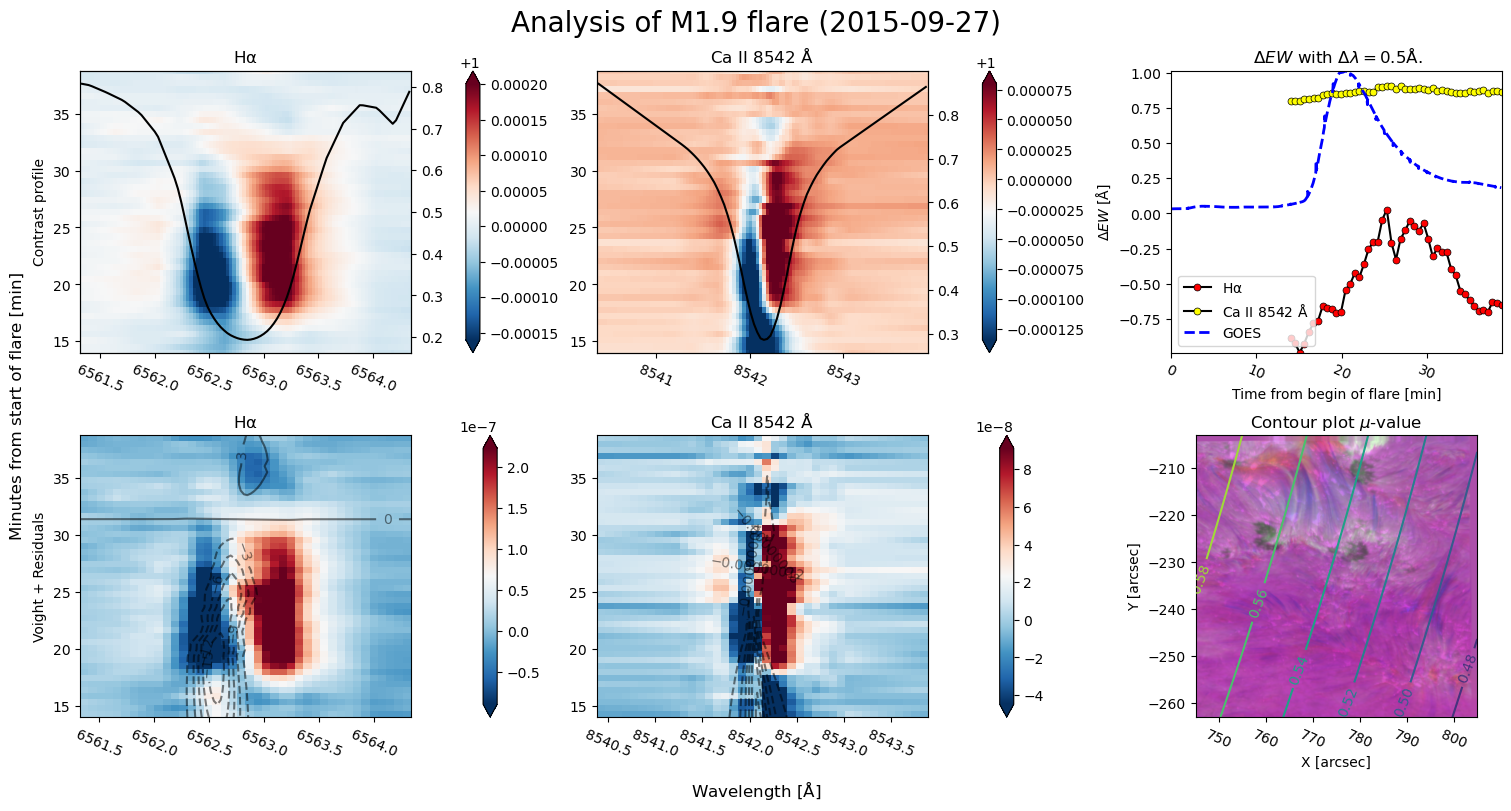

In [8]:
reload(un)
# lines
lines = ["Ha15a", "CaIR15a"]
# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "Analysis of M1.9 flare (2015-09-27)"

# make figure
fig, ax = plt.subplots(rows, cols, figsize=(5*cols,4*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)
fig.supylabel("Minutes from start of flare [min]")
fig.supxlabel(r"Wavelength [$\rm\AA$]")


# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigt residues and Mu plot

scalefactor = round(1/0.3,1)
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title)


fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

# C5.6 2015

<string>:22: SyntaxWarning: invalid escape sequence '\{'
<>:22: SyntaxWarning: invalid escape sequence '\{'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<string>:22: SyntaxWarning: invalid escape sequence '\{'
<>:22: SyntaxWarning: invalid escape sequence '\{'
<>:22: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_9332\4287654895.py:22: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_9332\4287654895.py:22: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line Ha15
plotting element Ha name: Ha15
vmax = 1.2397587394657214e-07, vmin = -1.008086646542139e-07
scaled flare: Line CaIR15
plotting element CaIR name: CaIR15
vmax = 2.1767830341970569e-07, vmin = -1.7383949545521138e-07
Ha15 Bounds: 0 -1.085602155034472
CaIR15 Bounds: 0.9898358581791786 -1.085602155034472
GOES: 1.0567009444072517 0.07591990736822077 1.0492408220359812

    \begin{figure*}
        \centering
        \includegraphics[width=0.75\linewidth]{Full_analysis_plots/Analysis_of_C5.6_flare_(2015-06-24).pdf}
        \caption{
    \textbf{The full Analysis of C5.6 flare (2015-06-24):} NESSI calculated full disk profiles 
    for ~20\% flare capture. \textbf{Upper left 2:} 
    Contrastprofiles to the quiet sun for the lines \Halpha and \CaIR.
    \textbf{Lower left 2:} voigtprofile fits to the respective contrastprofiles above are 
    shown using a contourmap, the residues to those fitting are shown using a color map. 
    \textbf{upper right:} Differential Equi

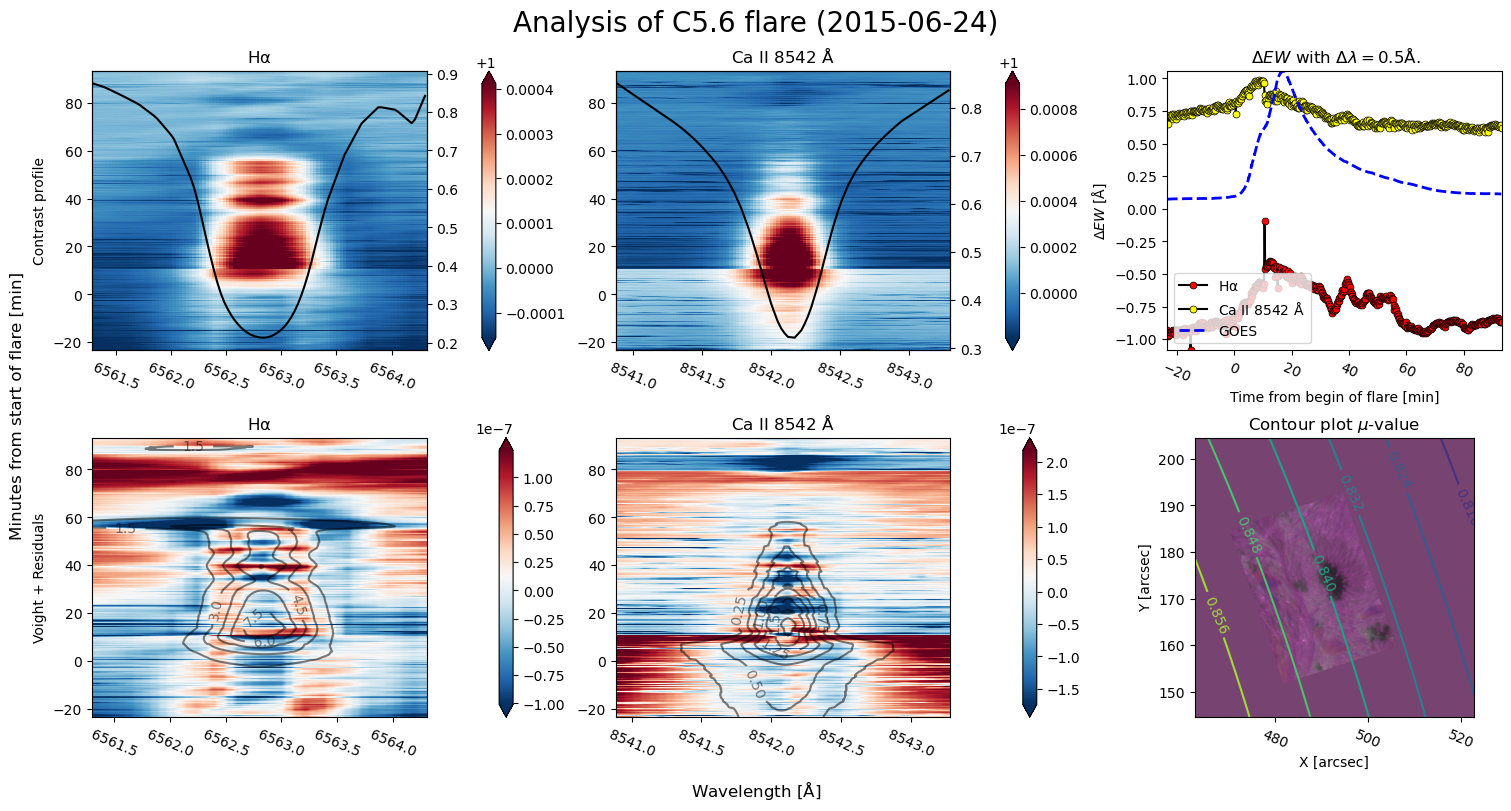

In [9]:
reload(un)
# lines
lines = ["Ha15", "CaIR15"]
# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "Analysis of C5.6 flare (2015-06-24)"

# make figure
fig, ax = plt.subplots(rows, cols, figsize=(5*cols,4*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)


# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigtresidues and Mu plot

scalefactor = round(5/1,1)
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title)


fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

**Figure Description**: \textbf{The full Analysis of the C5.6 flare:} NESSI calculated full disk profiles for assumed full flare capture. \textbf{Upper left 2:} Contrastprofiles to the quiet sun for the lines \Halpha and \CaIR. \textbf{Lower left 2:} voigt profile fits to the respective contrastprofiles above are shown using a contourmap, the residues to those fitting are shown using a color map. \textbf{upper right:} Differential Equivalent Width of the available lines as a function of time. \textbf{Lower right:} A cocoplot of the FOV in the \Halpha line at the start of the flare overlayed with contour lines of the $\mu$-value. 


**In text notice**: For the C5.6 full capture of the flare is assumed. The full flare analysis is plotted in \autoref{} in the same way as was done for the previous flares.
\Halpha encountered an increase of $8e-3\%$ and \CaK en increase of $0.015\%$. The contrast profiles show clearly the peak of the flare. In \CaIR a sharp transition is made around 12 minutes into the flare, approximately the peak of the flare. This change is visible over the entire band. Both in \Halpha and in \CaIR the flare is accompagned with a strong increase in the line center. In later times steadily appearing emmission in the wings can be seen. It seems as if the Telluric is also growing in strenght after the flare has happend. 
The voigt profile analysis around the discontinuity of \CaIR shows a similar jump. It seems as if the flare dies of instantly after this point in \CaIR. The DEW experience a discontinuity at the same time.